In [1]:
# Imports
import pandas as pd
import gzip
import json
from datetime import datetime
import re
import json
import pickle
import random
import numpy as np
import pandas as pd
from html import unescape
from  matplotlib import pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
from sklearn.feature_extraction import _stop_words
from collections import defaultdict, Counter
import pickle
import gensim
from gensim.models import FastText
from gensim.test.utils import common_texts  # some example sentences
from sklearn.model_selection import train_test_split
import operator
from random import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from datetime import datetime
from IPython.display import Markdown, display
from gensim.test.utils import common_texts  # some example sentences
from sklearn.model_selection import train_test_split
import operator
from random import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from datetime import datetime
import seaborn as sns



pd.set_option('display.max_colwidth', -1)
pd.options.mode.chained_assignment = None

<ipython-input-1-d0d377015c4d>:42: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Loading the Data, Cleaning it, and pickling it for much faster loading
Note: This section was run in a different Jupyter-lab notebook, and takes a VERY long time to run, so I would not suggest running this part
of the code

In [ ]:
# Loading data into dataframes from the .json.gz files using the code from http://jmcauley.ucsd.edu/data/amazon/index_2014.html

import pandas as pd
import gzip
import json
from datetime import datetime

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

start = datetime.now()
df_foods_2014 = getDF('reviews_Grocery_and_Gourmet_Food_5.json.gz')
print(datetime.now()-start)


start = datetime.now()
df_electronics_2014 = getDF('reviews_Electronics_5.json.gz')
print(datetime.now()-start)

start = datetime.now()
df_movietv_2014 = getDF('reviews_Movies_and_TV_5.json.gz')
print(datetime.now()-start)

0:00:04.613862
0:00:54.517311
0:01:06.231353


In [ ]:
# Original number of reviews for the 3 categories before filtering
print(len(df_foods_2014))
print(len(df_movietv_2014))
print(len(df_electronics_2014))

151254
1697533
1689188


In [ ]:
# Pickling the dataframes for much faster loading
df_foods_2014.to_pickle('df_foods_2014_all.p')
df_movietv_2014.to_pickle('df_movietv_2014_all.p')
df_electronics_2014.to_pickle('df_electronics_2014_all.p')

In [2]:
# Loading data from pickle files

start = datetime.now()
with open('df_electronics_2014_all.p', 'rb') as handle:
    df_electronics_2014 = pickle.load(handle)

with open('df_movietv_2014_all.p', 'rb') as handle:
    df_movietv_2014 = pickle.load(handle)
    
with open('df_books_2014_all.p', 'rb') as handle:
    df_books_2014 = pickle.load(handle) 
print(datetime.now()-start)
    
# with open('df_foods_2014_all.p', 'rb') as handle:
#     df_foods_2014 = pickle.load(handle)

0:03:10.620294


In [3]:
# Filtering reviews that don't receive a certian amount of total votes, and merging the categories into a single dataframe
# Note the 'helpful' column is a list of 2 values. 1 value is the amount of helpful votes, the other is the amount of TOTAL votes.

df_books_2014['category'] = 'Books'
df_electronics_2014['category'] = 'Electronics'
df_movietv_2014['category'] = 'Moviestv'

# filtering reviews that don't receive a certian amount of votes

min_votes = 10

start = datetime.now()
df_books_2014['tot_votes'] = df_books_2014['helpful'].map(lambda x:x[1])
df_books_2014 = df_books_2014[df_books_2014['tot_votes']>=min_votes]

df_electronics_2014['tot_votes'] = df_electronics_2014['helpful'].map(lambda x:x[1])
df_electronics_2014 = df_electronics_2014[df_electronics_2014['tot_votes']>=min_votes]

df_movietv_2014['tot_votes'] = df_movietv_2014['helpful'].map(lambda x:x[1])
df_movietv_2014 = df_movietv_2014[df_movietv_2014['tot_votes']>=min_votes]
print(datetime.now()-start)

df = df_books_2014.append(df_electronics_2014)
df = df.append(df_movietv_2014)
print(len(df))
print(datetime.now()-start)

0:07:06.675293
1109221
0:08:36.090118


In [4]:
# Deleting the individual dataframes, as they are no longer used (and to clear up some memory)
del df_movietv_2014
del df_electronics_2014
del df_books_2014

In [5]:
# Calculating like to dislike ratio

# All reviews with a ratio of likes to dislikes greater than 0.7 are categorized as unhelpful (same as https://arxiv.org/pdf/2008.10129.pdf)
def helpfulness_categorization(x):
    if x >= 0.7:
        return 1
    else:
        return 0

df['helpfull_ratio'] = df['helpful'].map(lambda x:x[0]/x[1])
df['class'] = df['helpfull_ratio'].map(lambda x:helpfulness_categorization(x))
print(len(df))

1109221


In [6]:
# Define function to clean text (removes all non-alphabetical characters and lower cases the text)
def clean(text):
    text = unescape(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = ' '.join([w.lower() for w in text.split()])
    return text

In [7]:
# Applying the cleaning function
start = datetime.now()
df['cleaned_text'] = df.reviewText.map(lambda x: clean(x))
print(datetime.now()-start)

0:03:21.398962


In [8]:
# Tokenize the text
start = datetime.now()
df['cleaned_text_lst'] = df['cleaned_text'].map(lambda x:x.strip().split(' '))
print(datetime.now()-start)

0:06:54.888933


In [86]:
# Loading wikinews 1M fasttext embeddings into a dictionnary
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.fromiter(map(float, tokens[1:]),dtype = np.float)
    return data

start = datetime.now()
fast_text_vecs = load_vectors(r'C:\Users\plize\Documents\GitHub\Natural Naguage Processing\Summative\wiki-news-300d-1M-subword.vec\wiki-news-300d-1M-subword.vec')
print(datetime.now()-start)

0:04:06.433620


In [108]:
################################# Loading fasttext emdeddings 

# Pickling the embeddings for much faster loading

with open('fast_text_vecs_wikinews.p', 'wb') as handle:
    pickle.dump(fast_text_vecs, handle, protocol=pickle.HIGHEST_PROTOCOL)

##########################################################
# start = datetime.now()
# with open('fast_text_vecs_wikinews.p', 'rb') as handle:
#     fast_text_vecs = pickle.load(handle)

# fasttest_dict = model2.wv.key_to_index
# embedding_vals = model2.wv
# fast_text_vecs = {word:embedding_vals[word] for word in  fasttest_dict}

print(datetime.now()-start)

0:00:10.991388


In [17]:
# Filtering all reviews with a length more than 500 words, and a length less than 25
df['len'] = df['cleaned_text_lst'].map(lambda x:len(x))
df = df[df['len']<=500]
df = df[df['len']>=25]


In [4]:
# Remove columnns that are not needed and drop duplicate reviews
start = datetime.now()
df = df.drop(columns=['asin','reviewerID','reviewerName','unixReviewTime'])
df = df.drop_duplicates(subset=['cleaned_text'])
df = df.rename(columns={"class": "helpfulness_binary"})
df.shape
print(datetime.now()-start)

0:00:15.622754


In [7]:
# Cleaning the review summary and tokenising it
df['summary_cleaned'] = df.summary.map(lambda x: clean(x))
start = datetime.now()
df['summary_cleaned'] = df['summary_cleaned'].map(lambda x:x.strip().split(' '))
print(datetime.now()-start)


0:03:13.502440


In [8]:
# Categorizing the review rating
# 1-2 star reviews are assigned "0"
# 3 star reviews are assigned "1"
# 4-5 star reviews are assigned "2"
def categorize_ratings(x):
    if x in (1,2):
        return 0
    if x == 3:
        return 1
    if x in (4,5):
        return 2
    
df['rating_category'] = df['overall'].map(lambda x:categorize_ratings(x))

In [9]:
# Shwoing counts of each class (for each category) to see how much I need to downsample
df[['category','helpfulness_binary','rating_category']].value_counts(sort=False)

category     helpfulness_binary  rating_category
Books        0                   0                  122084
                                 1                  31114 
                                 2                  64625 
             1                   0                  62502 
                                 1                  47761 
                                 2                  333440
Electronics  0                   0                  11241 
                                 1                  3192  
                                 2                  4517  
             1                   0                  10338 
                                 1                  6723  
                                 2                  49209 
Moviestv     0                   0                  52172 
                                 1                  11281 
                                 2                  18520 
             1                   0                  9451  
       

It is clear that the Electronics data has a relatively small sample size compared to the other categories (especially for unhelpful positive/neutral reviews). Therefore, to ensure datasets are sufficiently large for some of the deep learning techniques used later, the electronics category will be dropped. Moreover, after dropping the Electronics category, the class/category with the smallest sample size are Movies & TV reviews that are both helpful and with a moderate rating (in total there is 9252 samples for this category/class from the above). Consequently, I round this down to the nearest 1000, and and will take a random sample of 9000 examples from each category\class.

In [10]:
# Mapping the rating and helpfulness into 6 classes
####### Class Mappings: ########
# 0 = Bad Rating and NOT helpful
# 1 = Bad Rating and helpful
# 2 = Medium rating and NOT helpful
# 3 = Medium rating and helpful
# 4 = Good rating and NOT helpful
# 5 = Good rating and helpful

df['class'] = 2*df['rating_category'] + df['helpfulness_binary']

In [11]:
# Taking a random sample of 9,000 reviews for each class for each category and dropping the electronics category
# Then splitting the data into training, dev and test sets with balanced category membership, where the training set has 7000 examples per
# class, the dev set 1000, and the test set 1000 (per category)
categories = pd.unique(df['category']).tolist()

i = 0

for category in ['Books','Moviestv']:
    for class_num in range(6):

        df_t1 = df.copy()[df['category']==category]
        df_good = df_t1[df_t1['class']==class_num]
#         print(df_good.shape)
        df_good = df_good.sample(n=9000)
    #     df_bad = df_t1[df_t1['helpfulness_binary']==0]
    #     df_bad = df_bad.sample(n=18000)

        # Train test splitting the data (15,000 examples per class for the training set, 1500 examples for the dev set and the same for the test set)
        df_train_temp,df_dev_test = train_test_split(df_good, test_size=0.22222, random_state=1)
    #     df_bad_train,df_bad_dev_test = train_test_split(df_bad, test_size=0.166666, random_state=1)

        df_test_temp,df_dev_temp = train_test_split(df_dev_test, test_size=0.5, random_state=1)

    #### May have been an issue here in the original code when I split the data
#         df_good_test,df_good_dev = train_test_split(df_bad_dev_test, test_size=0.5, random_state=1)
    #     df_bad_test,df_bad_dev = train_test_split(df_good_dev_test, test_size=0.5, random_state=1)

#         df_train_temp = df_good_train.append(df_bad_train)
#         df_test_temp = df_good_test.append(df_bad_test)
#         df_dev_temp = df_good_dev.append(df_bad_dev)

        if i == 0:
            df_train = df_train_temp
            df_test = df_test_temp
            df_dev = df_dev_temp

        else:
            df_train = df_train_temp.append(df_train)
            df_test = df_test_temp.append(df_test)
            df_dev = df_dev_temp.append(df_dev)
#         print(df_train.shape)
        i += 1

#     print(df_train['helpfulness_binary'].value_counts())
#     display(df_train['summary'])

In [13]:
# Displaying what the cleaned summaries look like
df['summary_cleaned'].head()

34    [simple, wisdom]                        
43    [the, most, loving, book, ever, written]
46    [the, lessons, of, life]                
75    [divine, wisdom, in, earthly, words]    
76    [unexpected, purchase]                  
Name: summary_cleaned, dtype: object

In [14]:
display(df_train['class'].value_counts())

5    14000
4    14000
3    14000
2    14000
1    14000
0    14000
Name: class, dtype: int64

In [15]:
display(df_dev['class'].value_counts())

5    2000
4    2000
3    2000
2    2000
1    2000
0    2000
Name: class, dtype: int64

In [16]:
display(df_test['class'].value_counts())

5    2000
4    2000
3    2000
2    2000
1    2000
0    2000
Name: class, dtype: int64

In [18]:
# Calculating other metrics that will be used later in the analysis (the date and review length)

start = datetime.now()
# Extracting year of each review
df_train['review_year'] = df_train['reviewTime'].map(lambda x: int(x[-4:]))
df_dev['review_year'] = df_dev['reviewTime'].map(lambda x: int(x[-4:]))
df_test['review_year'] = df_test['reviewTime'].map(lambda x: int(x[-4:]))
print(datetime.now()-start)



# Normalizing years feature
min_review_year = df_train['review_year'].min()
max_review_year = df_train['review_year'].max()


df_train['review_year_normalized'] = (df_train['review_year'] - min_review_year)/(max_review_year-min_review_year)
df_dev['review_year_normalized'] = (df_dev['review_year'] - min_review_year)/(max_review_year-min_review_year)
df_test['review_year_normalized'] = (df_test['review_year'] - min_review_year)/(max_review_year-min_review_year)

# Normalizing length feature
min_len= df_train['len'].min()
max_len= df_train['len'].max()


df_train['len_normalized'] = (df_train['len'] - min_len)/(max_len-min_len)
df_dev['len_normalized'] = (df_dev['len'] - min_len)/(max_len-min_len)
df_test['len_normalized'] = (df_test['len'] - min_len)/(max_len-min_len)

print(datetime.now() - start)




0:08:22.736829
0:08:22.748835


In [20]:
# Dropping the review time, since it is no longer used in the analysis
df_train = df_train.drop(columns=['reviewTime'])
df_dev = df_dev.drop(columns=['reviewTime'])
df_test = df_test.drop(columns=['reviewTime'])


In [21]:
# Saving the final form of the training, dev and test dataframes
df_train.to_pickle('df_train.p')
df_dev.to_pickle('df_dev.p')
df_test.to_pickle('df_test.p')


## Loading Cleaned Data

In [2]:
################################# Loading fasttext emdeddings 

# with open('fast_text_vecs_wikinews.p', 'wb') as handle:
#     pickle.dump(fast_text_vecs, handle, protocol=pickle.HIGHEST_PROTOCOL)

##########################################################
start = datetime.now()
with open('fast_text_vecs_wikinews.p', 'rb') as handle:
    fast_text_vecs = pickle.load(handle)

# fasttest_dict = model2.wv.key_to_index
# embedding_vals = model2.wv
# fast_text_vecs = {word:embedding_vals[word] for word in  fasttest_dict}

print(datetime.now()-start)

0:00:08.172790


In [3]:
####### Class Mapping: ########
# 0 = Bad Rating and NOT helpful
# 1 = Bad Rating and helpful
# 2 = Medium rating and NOT helpful
# 3 = Medium rating and helpful
# 4 = Good rating and NOT helpful
# 5 = Good rating and helpful

start = datetime.now()
with open('df_train.p', 'rb') as handle:
    df_train = pickle.load(handle)
    
with open('df_dev.p', 'rb') as handle:
    df_dev = pickle.load(handle)
    
with open('df_test.p', 'rb') as handle:
    df_test = pickle.load(handle)
    
    
print(datetime.now()-start)

0:00:15.139215


# Exploratory Analysis

In [4]:
# Examining the head of the training dataframe (The reviews are very long so only including 3 examples here)

df_train.head(3)

,helpful,reviewText,overall,summary,category,tot_votes,helpfull_ratio,helpfulness_binary,cleaned_text,cleaned_text_lst,len,summary_cleaned,rating_category,class,review_year,review_year_normalized,len_normalized
578449,"[9, 10]","William Katt and Kay Lenz star in the 1986 horror film.A writer moves into his Aunt's home discovering thatit's full of strange things. Arye Gross and JonathanStark star in the 1987 horror sequel. A young maninherits his parents home and finds an ancient skullalong with his ancestor. I've always enjoyed thesefilms and it's nice to have both together that havegood picture and sound plus a couple neat extras.If you like great 80's horror, I recommend these.",4.0,"""Great 80's Horror!""",Moviestv,10,0.900000,1,william katt and kay lenz star in the horror film a writer moves into his aunt s home discovering thatit s full of strange things arye gross and jonathanstark star in the horror sequel a young maninherits his parents home and finds an ancient skullalong with his ancestor i ve always enjoyed thesefilms and it s nice to have both together that havegood picture and sound plus a couple neat extras if you like great s horror i recommend these,"[william, katt, and, kay, lenz, star, in, the, horror, film, a, writer, moves, into, his, aunt, s, home, discovering, thatit, s, full, of, strange, things, arye, gross, and, jonathanstark, star, in, the, horror, sequel, a, young, maninherits, his, parents, home, and, finds, an, ancient, skullalong, with, his, ancestor, i, ve, always, enjoyed, thesefilms, and, it, s, nice, to, have, both, together, that, havegood, picture, and, sound, plus, a, couple, neat, extras, if, you, like, great, s, horror, i, recommend, these]",80,"[great, s, horror]",2,5,2010,0.777778,0.115789
848570,"[12, 13]","still this product shows us the brutality of Manson first hand. In 1976, the tv-film gave us a chilling insight into intelligent madness - yup who can deny that the brain of Manson in not unlike Hitler; mad, but with vision and control of the environment.....In this version we get to know the victims... they`re no longer just names and figures... The last scene in which Sharon whispers ""Cut the baby"" to Susan Atkins never happened, but she d i d try to negotiate with her killers; ""take me with you, let me have my baby and then kill me"" and ""can you remove the baby from the womb"" when she realised there was no hope...This is a trashy account of the story and it SUCCEEDS in showing us that the kilings were not some sort of great ritualistic thing as been presented over the years.... But this was a total senseless massacre and THAT`s why this film succeeds; it speaks volumes why not the killers should ever be released.",4.0,"It doesn`t surpass the 1976 outing, but...",Moviestv,13,0.923077,1,still this product shows us the brutality of manson first hand in the tv film gave us a chilling insight into intelligent madness yup who can deny that the brain of manson in not unlike hitler mad but with vision and control of the environment in this version we get to know the victims they re no longer just names and figures the last scene in which sharon whispers cut the baby to susan atkins never happened but she d i d try to negotiate with her killers take me with you let me have my baby and then kill me and can you remove the baby from the womb when she realised there was no hope this is a trashy account of the story and it succeeds in showing us that the kilings were not some sort of great ritualistic thing as been presented over the years but this was a total senseless massacre and that s why this film succeeds it speaks volumes why not the killers should ever be released,"[still, this, product, shows, us, the, brutality, of, manson, first, hand, in, the, tv, film, gave, us, a, chilling, insight, into, intelligent, madness, yup, who, can, deny, that, the, brain, of, manson, in, not, unlike, hitler, mad, but, with, vision, and, control, of, the, environment, in, this, version, we, get, t

In [5]:
# Dsiplaying the length of reviews and summaries
shortest_title = df_train['summary_cleaned'].map(lambda x: len(x)).min()
longest_title = df_train['summary_cleaned'].map(lambda x: len(x)).max()

shortest_body = df_train['cleaned_text_lst'].map(lambda x: len(x)).min()
longest_body = df_train['cleaned_text_lst'].map(lambda x: len(x)).max()

print('Shortest review is',shortest_body,'words')
print('Longest review is',longest_body,'words')
print('Shortest summary is',shortest_title,'words')
print('Longest summary is',longest_title,'words')

Shortest review is 25 words
Longest review is 500 words
Shortest summary is 1 words
Longest summary is 29 words


In [6]:
# Getting the label associated with each class number
label2id = {'Unhelpful- Negative Sentiment':0,'Helpful- Negative Sentiment':1,\
           'Unhelpful- Medium Sentiment':2,'Helpful- Medium Sentiment':3,\
           'Unhelpful- Positive Sentiment':4,'Helpful- Positive Sentiment':5}
id2label = {val:key for key,val in label2id.items()}
categories = ['Moviestv','Books']

In [7]:
# Getting review embeddings (as the mean embedding of the embeddings of each word). This will be used later for TSNE plots.


import math
reviews = df_train['cleaned_text_lst']
def review_to_vec(a, vecs):
    # Fasttext may not have all words in the reivews in its vocabulary, so exclude these words (most likely extremely rare words)
    return np.array([vecs[w] for w in a if w in vecs and w not in _stop_words.ENGLISH_STOP_WORDS]).mean(axis=0) # Fasttext embeddings may not 


df_train['review_length'] = df_train['cleaned_text_lst'].map(lambda x: math.log(len(x)))
df_train['review_tot_embedding'] = df_train['cleaned_text_lst'].map(lambda x: review_to_vec(x,fast_text_vecs))
# df_train['review_embedding_lst'] = df_train['cleaned_text_lst'].map(lambda x: review_to_embeddings_lst(x,fast_text_vecs,mean_fasttext_embedding))


df_test['review_length'] = df_test['cleaned_text_lst'].map(lambda x: math.log(len(x)))
df_test['review_tot_embedding'] = df_test['cleaned_text_lst'].map(lambda x: review_to_vec(x,fast_text_vecs))
# df_test['review_embedding_lst'] = df_test['cleaned_text_lst'].map(lambda x: review_to_embeddings_lst(x,fast_text_vecs,mean_fasttext_embedding))


df_train_nn = df_train.copy().dropna(subset=['review_tot_embedding'])
# df_train_nn = df_train_nn[df_train_nn['review_length']<6.0]
df_test_nn = df_test.copy().dropna(subset=['review_tot_embedding'])

In [8]:
# For cleaner coding during this exploratory phase, creating a dictionnary of the Movies and TV data, and the Books data

df_category_dict = dict()
df_category_dict['Moviestv'] = df_train.copy()[df_train['category']=='Moviestv']
df_category_dict['Books'] = df_train.copy()[df_train['category']=='Books']

In [9]:
# Class membership
df_train['class'].value_counts()
# df_test_nn.shape

5    14000
4    14000
3    14000
2    14000
1    14000
0    14000
Name: class, dtype: int64

<AxesSubplot:title={'center':'Distribution of the Year Reviews Were Posted in the Training Set by Category'}>

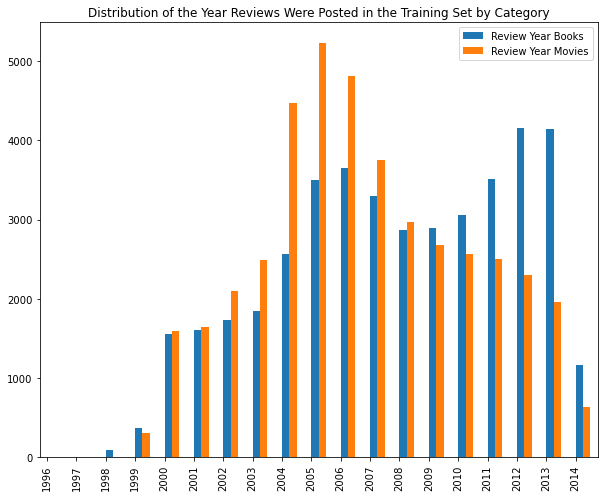

In [10]:
# Plotting distribution of the year reviews were posted for each category

years_movies = df_category_dict['Moviestv']['review_year'].value_counts().sort_index()
years_books = df_category_dict['Books']['review_year'].value_counts().sort_index()
years_movies.name = 'Review Year Movies'
years_books.name = 'Review Year Books'
year_both = pd.concat([years_movies, years_books], axis=1)
# year_both.columns += '_some_suffix'

# year_both
year_both

year_both.plot(use_index=True, y=['Review Year Books','Review Year Movies'],kind='bar',title ='Distribution of the Year Reviews Were Posted in the Training Set by Category',position =0,width=0.5,figsize=(10,8))

-------------------------- Moviestv --------------------------




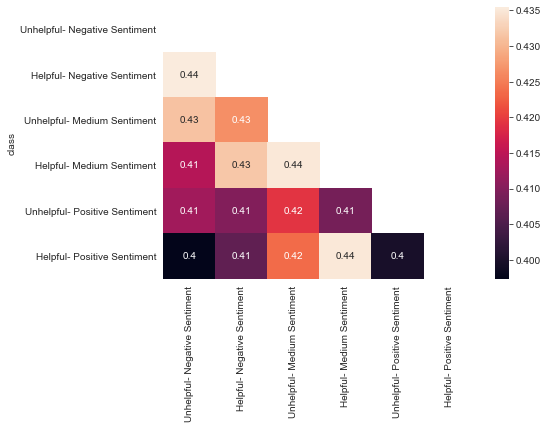

-------------------------- Books --------------------------




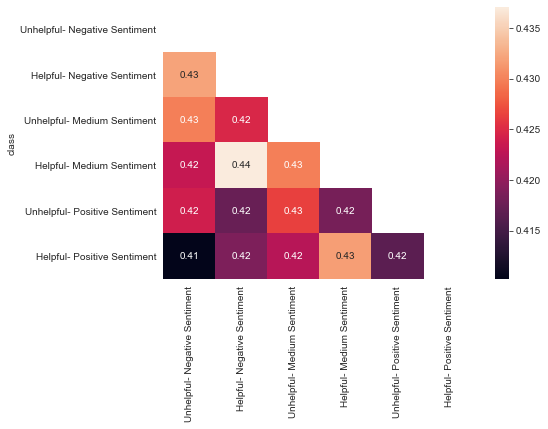

In [11]:
# Getting vocabulary for each class and plotting a heatmap of the Jaccard similarities (Only looking at the matrix below the diagonal,
# Since the matrix is symmetric, with diagonal values equal to 1)

mat_jaccard = np.zeros((6,6))
for category in categories:
    print('--------------------------',category,'--------------------------\n\n')
    df_category_dict
    class_vocab = dict()
    for class_num in range(6):
        df_temp = df_category_dict[category][df_category_dict[category]['class']==class_num]
        class_vocab[class_num] = set([word for review in df_temp['cleaned_text_lst'] for word in review])
    class_vocab_min = dict()
    for i in range(6):
        for j in range(6):
            intercection_sets = class_vocab[i].intersection(class_vocab[j])
            union_sets = class_vocab[i].union(class_vocab[j])
            mat_jaccard[i,j] = len(intercection_sets)/len(union_sets)
    df_jaccard = pd.DataFrame(mat_jaccard,columns = label2id.keys())
    df_jaccard['class'] = pd.Series(label2id.keys())
    df_jaccard = df_jaccard.set_index(['class'])
    mask = np.zeros_like(mat_jaccard)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(7, 5))
        ax = sns.heatmap(df_jaccard, mask=mask, annot=True)
        plt.show()



We can see that the Jaccard similarities of each class are very similar, most likely due to such a large vocabulary from rare words. To reduce this issue, I will only includes words that appear in a class more than 5 times to include it in the Jaccard similarity calculation

In [12]:
# Creating voacbulary counts for Jaccard similarities (with min doc counts) ziff plot, as well as for MI calculation


category_vocab = dict()
category_n_posts = dict()

for rev_category in ['Moviestv','Books']:
    df_category = df_category_dict[rev_category]

    random_seed = 123


    categories = pd.unique(df_train['class']).tolist()

    # Initialize data structures
    train_dict = defaultdict(list)
    test_dict= defaultdict(list)

    # put the content of the reviews in a default dict
    for c_i in categories:
        train_dict[c_i] =  df_category[df_category['class']==c_i].copy()['cleaned_text_lst'].to_list()

    # Initialize data structures
    vocab = defaultdict(Counter)
    n_posts = defaultdict(Counter)

    # Create vocabularies for words in each class
    for c_i in categories:
        for p in train_dict[c_i]:
            vocab[c_i].update(p)
            n_posts[c_i].update(set(p))

    # Create vocabularies for words NOT in each class (useful more MI)
    for c_i in categories:
        for c_j in categories:
            if c_i != c_j:
                vocab['not_' + str(c_i)].update(vocab[c_j])
                n_posts['not_' +str(c_i)].update(n_posts[c_j])

    category_vocab[rev_category] = vocab
    category_n_posts[rev_category] = n_posts

-------------------------- Moviestv --------------------------




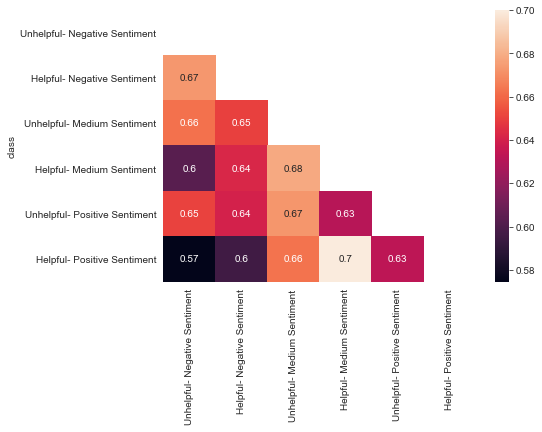

-------------------------- Books --------------------------




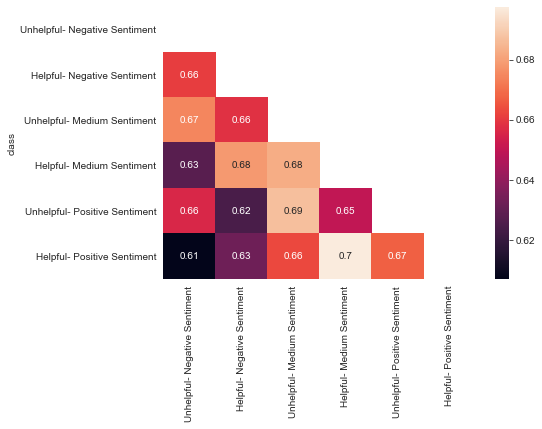

In [13]:
# Getting vocabulary for each class

categories = ['Moviestv','Books']
min_docs_word = 5
for category in categories:
    print('--------------------------',category,'--------------------------\n\n')
    class_vocab = dict()
    for class_num in range(6):
        df_temp = df_category_dict[category][df_category_dict[category]['class']==class_num]
        class_vocab[class_num] = set([word for review in df_temp['cleaned_text_lst'] for word in review])
    class_vocab_min = dict()
    for class_num in range(6):
        class_vocab_min[class_num] = {w for w in class_vocab[class_num] if category_n_posts[category][class_num][w]>=min_docs_word}
        mat_jaccard = np.zeros((6,6))
    for i in range(6):
        for j in range(6):
            intercection_sets = class_vocab_min[i].intersection(class_vocab_min[j])
            union_sets = class_vocab_min[i].union(class_vocab_min[j])
            mat_jaccard[i,j] = len(intercection_sets)/len(union_sets)
    df_jaccard = pd.DataFrame(mat_jaccard,columns = label2id.keys())
    df_jaccard['class'] = pd.Series(label2id.keys())
    df_jaccard = df_jaccard.set_index(['class'])
    mask = np.zeros_like(mat_jaccard)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(7, 5))
        ax = sns.heatmap(df_jaccard, mask=mask, annot=True)
        plt.show()

From the Jaccard similarities we can see that both the movies and books category have similar jaccard simiarity rankings for each class. Negative rating reviews and positive reviews, have the lowest jaccard similarity with each other when the helpfulness between the classes differers (i.e. negative rating, non helpful vs positive helpful), which makes sense, as these classes should intuitively be the most different. Moderate rating and unhelpful reviews are most similar to Moderate rating and helpful reviews, but the reverse is not true. It appears that helpful moderate rating reviews are most similar to positive rating helpful reviews and the converse is true as well. It appears that a classifier may have trouble distuiguinshing between these two classes, as they also have the highest Jaccard similarity in the matrix. Therefore it is clear that a model that leverages content alone would likely struggle most distuinguishing the sentiment of helpful positive/neutral reviews.

### Repeating the same procedure to calculate Jaccard similarities between classes for review summaries

-------------------------- Moviestv --------------------------




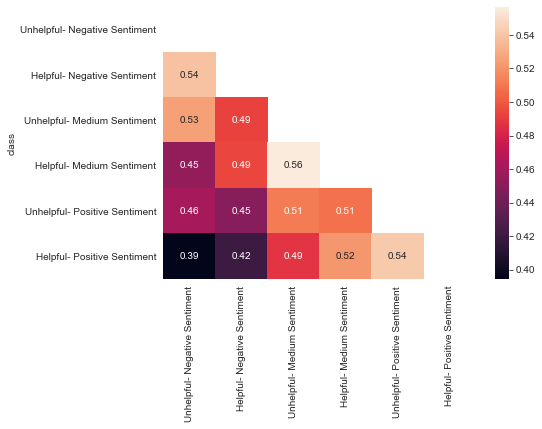

-------------------------- Books --------------------------




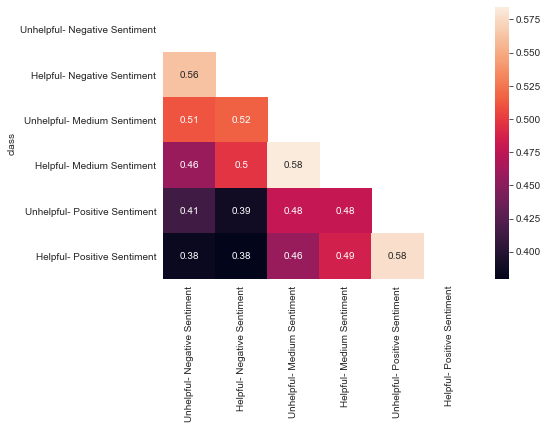

In [14]:
# Looking at Jaccard similarity for the summaries


# Creating voacbulary counts for Jaccard similarities (with min doc counts) ziff plot, as well as for MI calculation


category_vocab_summaries = dict()
category_n_posts_summaries = dict()

for rev_category in ['Moviestv','Books']:
    df_category = df_category_dict[rev_category]

    random_seed = 123


    categories = pd.unique(df_train['class']).tolist()

    # Initialize data structures
    train_dict_summaries= defaultdict(list)

    # put the content of the reviews in a default dict
    for c_i in categories:
        train_dict_summaries[c_i] =  df_category[df_category['class']==c_i].copy()['summary_cleaned'].to_list()

    # Initialize data structures
    vocab_summaries = defaultdict(Counter)
    n_posts_summaries = defaultdict(Counter)

    # Create vocabularies for words in each class
    for c_i in categories:
        for p in train_dict_summaries[c_i]:
            vocab_summaries[c_i].update(p)
            n_posts_summaries[c_i].update(set(p))

    category_vocab_summaries[rev_category] = vocab_summaries
    category_n_posts_summaries[rev_category] = n_posts_summaries



# Getting vocabulary for each class

categories = ['Moviestv','Books']
min_docs_word = 5
for category in categories:
    print('--------------------------',category,'--------------------------\n\n')
    class_vocab_summaries = dict()
    for class_num in range(6):
        df_temp = df_category_dict[category][df_category_dict[category]['class']==class_num]
        class_vocab_summaries[class_num] = set([word for review in df_temp['summary_cleaned'] for word in review])
    class_vocab_min_summaries = dict()
    for class_num in range(6):
        class_vocab_min_summaries[class_num] = {w for w in class_vocab_summaries[class_num] if category_n_posts_summaries[category][class_num][w]>=min_docs_word}
        mat_jaccard = np.zeros((6,6))
    for i in range(6):
        for j in range(6):
            intercection_sets = class_vocab_min_summaries[i].intersection(class_vocab_min_summaries[j])
            union_sets = class_vocab_min_summaries[i].union(class_vocab_min_summaries[j])
            mat_jaccard[i,j] = len(intercection_sets)/len(union_sets)
        df_jaccard = pd.DataFrame(mat_jaccard,columns = label2id.keys())
        df_jaccard['class'] = pd.Series(label2id.keys())
        df_jaccard = df_jaccard.set_index(['class'])
        mask = np.zeros_like(mat_jaccard)
        mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(7, 5))
        ax = sns.heatmap(df_jaccard, mask=mask, annot=True)
        plt.show()




In terms of the summaries, the movies and tv as well as books category have similar jaccard similarity matrices. The vocabulary of positive sentiment reviews are most different from negative reviews. However, it appears that the jaccard similarity between helpful and unhelpful reviews accross the matrix are high relative to the sentiment (for instance the highest jaccard similarity between unhelpful negative sentiment reviews and helpful reviews is the highest, which means a classifier using summaries may have trouble distuinguishing between helpful reviews). This appears to be the opposite issue as the content of reviews, where the vocabularies of the content of helpfil positive/neutral reviews make it difficult to differentiate them. It therefore appears we will get some useful additional information regarding the sentiment that the content is lacking

In [15]:
# Getting vocabulay of each category to plot the Ziff plots of the Movies and TV and Books categories
train_dict_all = defaultdict(list)

# train_dict_all = dict()
for c_k in ['Moviestv','Books']:
    train_dict_all[c_k] =  df_train[df_train['category']==c_k].copy()['cleaned_text_lst'].to_list()

# Initialize data structures
vocab_by_review_category = defaultdict(Counter)
n_posts_by_review_category = defaultdict(Counter)
    
for c_i in ['Moviestv','Books']:
    for p in train_dict_all[c_i]:
        vocab_by_review_category[c_i].update(p)
        n_posts_by_review_category[c_i].update(set(p))

Books


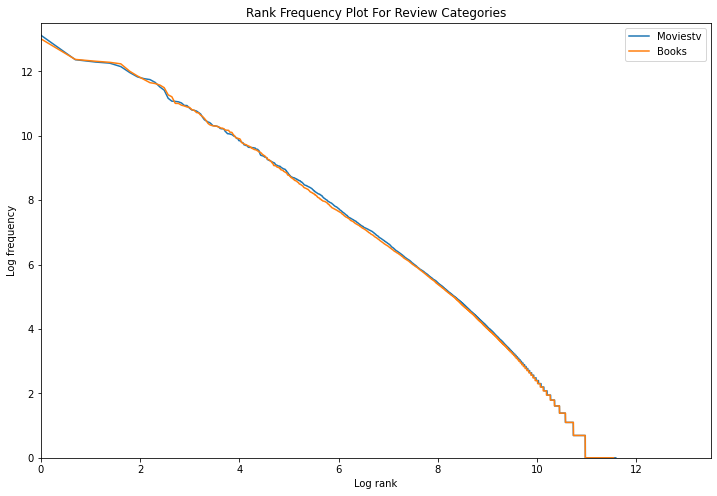

In [16]:
# Plotting the rank frequency plots of the 2 categories

# Initialize dictionary to store rank-frequency distributions
freq_dists = dict()

i = 0
# Initialize figure
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
# axes = axes.ravel()

print(c_i)

    
# Generate list of sorted counts
freq_dists[2*c_i] = [c for w, c in vocab_by_review_category['Moviestv'].most_common()]

# Convert to log counts
y = [np.log(c) for c in freq_dists[2*c_i]]


#     # Generate list of sorted log counts for RANDOM category
y_helpful = [np.log(c) for w, c in vocab_by_review_category['Books'].most_common()]

# Generate list of log ranks
x = [np.log(r) for r in list(range(1, len(y) + 1))]
x_random = [np.log(r) for r in list(range(1, len(y_helpful) + 1))]


# Generate plot    
axes.plot(x, y, label='Moviestv')
axes.plot(x_random, y_helpful, label='Books')
axes.set_xlim(0, 13.5)
axes.set_ylim(0, 13.5)
axes.set_title('Rank Frequency Plot For Review Categories')
axes.set_xlabel('Log rank')
axes.set_ylabel('Log frequency')
axes.legend()
i += 1

plt.show()

0
2
4


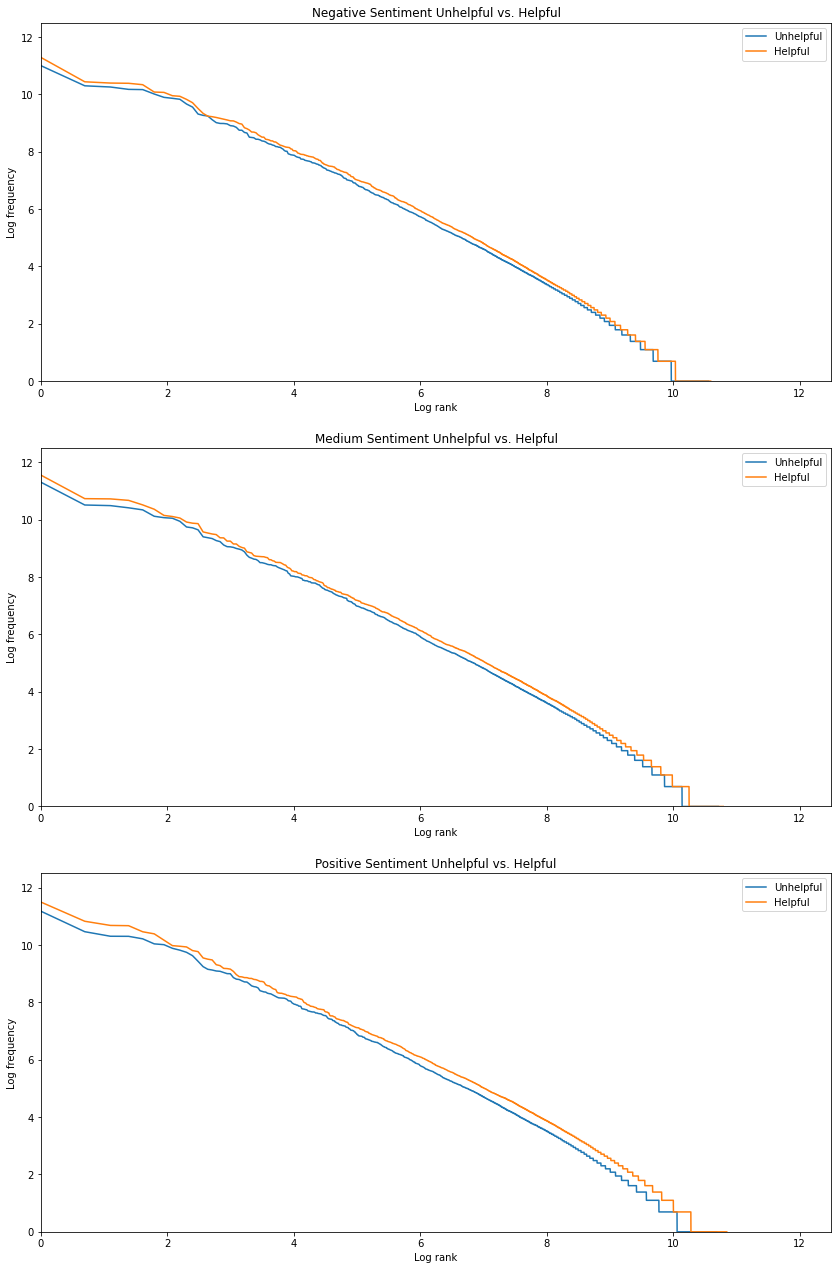

In [17]:
# Now plotting the rank frequency plot between each class, based on helpfulness

freq_dists = dict()

# Initialize figure
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
axes = axes.ravel()

category = 'Moviestv'

i = 0
for c_i in range(0,6,2):
    print(c_i)
    
    # Generate list of sorted counts
    freq_dists[2*c_i] = [c for w, c in category_vocab[category][c_i].most_common()]
    
    # Convert to log counts
    y = [np.log(c) for c in freq_dists[2*c_i]]
    
        
#     # Generate list of sorted log counts for RANDOM category
    y_helpful = [np.log(c) for w, c in category_vocab[category][c_i+1].most_common()]
    
    # Generate list of log ranks
    x = [np.log(r) for r in list(range(1, len(y) + 1))]
    x_random = [np.log(r) for r in list(range(1, len(y_helpful) + 1))]
    
    # Generate plot    
    axes[i].plot(x, y, label='Unhelpful')
    axes[i].plot(x_random, y_helpful, label='Helpful')
    axes[i].set_xlim(0, 12.5)
    axes[i].set_ylim(0, 12.5)
    axes[i].set_title('{} Unhelpful vs. Helpful'.format(id2label[c_i][11:]))
    axes[i].set_xlabel('Log rank')
    axes[i].set_ylabel('Log frequency')
    axes[i].legend()
    i += 1
fig.tight_layout(pad=2.0)

plt.show()

Performing the same plots for the books category

0
2
4


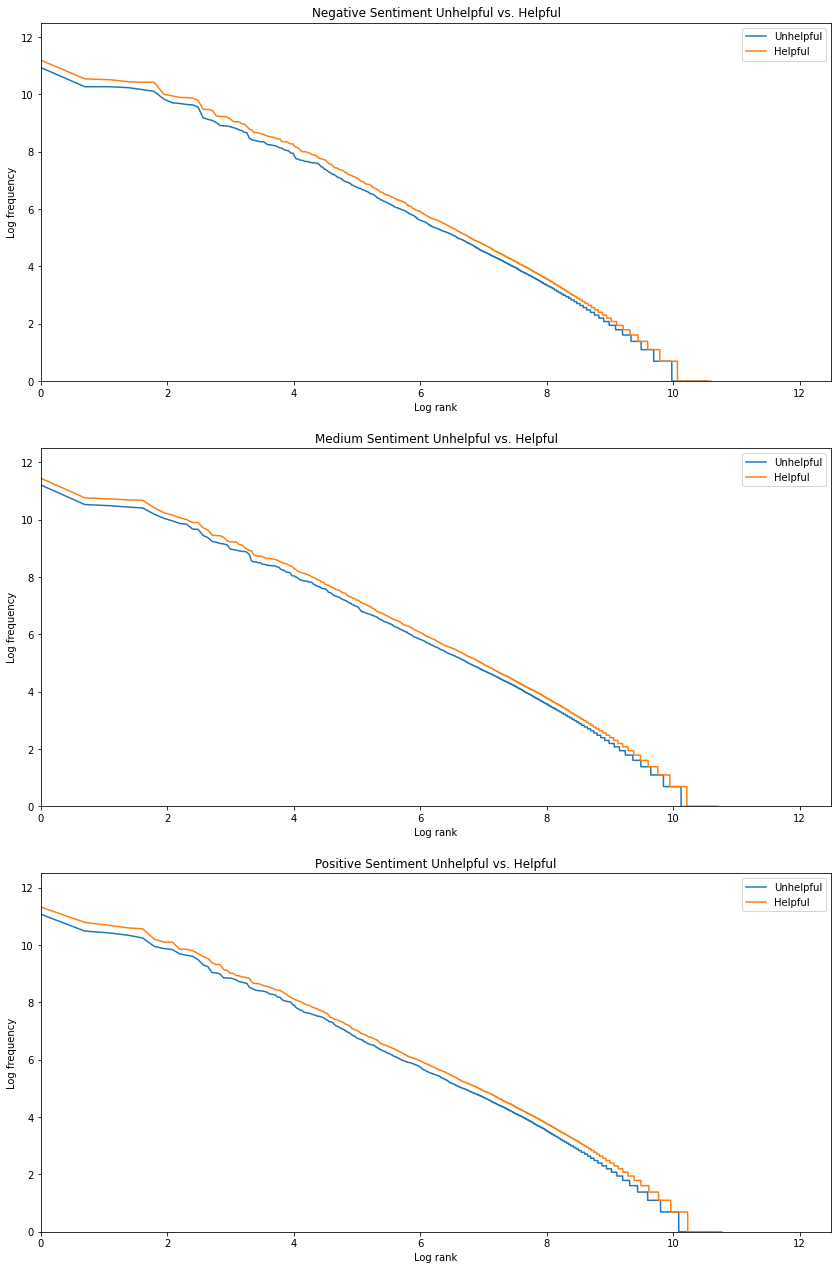

In [18]:
# Initialize dictionary to store rank-frequency distributions
freq_dists = dict()

# Initialize figure
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
axes = axes.ravel()

category = 'Books'

i = 0
for c_i in range(0,6,2):
    print(c_i)
    
    # Generate list of sorted counts
    freq_dists[2*c_i] = [c for w, c in category_vocab[category][c_i].most_common()]
    
    # Convert to log counts
    y = [np.log(c) for c in freq_dists[2*c_i]]
    
        
#     # Generate list of sorted log counts for RANDOM category
    y_helpful = [np.log(c) for w, c in category_vocab[category][c_i+1].most_common()]
    
    # Generate list of log ranks
    x = [np.log(r) for r in list(range(1, len(y) + 1))]
    x_random = [np.log(r) for r in list(range(1, len(y_helpful) + 1))]
    
    # Generate plot    
    axes[i].plot(x, y, label='Unhelpful')
    axes[i].plot(x_random, y_helpful, label='Helpful')
    axes[i].set_xlim(0, 12.5)
    axes[i].set_ylim(0, 12.5)
    axes[i].set_title('{} Unhelpful vs. Helpful'.format(id2label[c_i][11:]))
    axes[i].set_xlabel('Log rank')
    axes[i].set_ylabel('Log frequency')
    axes[i].legend()
    i += 1
fig.tight_layout(pad=2.0)

plt.show()

In [19]:
# For each review, find that percentage of words that appear in both the summary and content, divided by the length of the summary
# (Originally wanted to use Jaccard similarity, but the values were extremely small because the review content is significantly larger than
# the review summaries)
for category in categories:

    vocab_every_content = [Counter(rev) for rev in df_category_dict[category]['cleaned_text_lst']]
    vocab_every_summary = [Counter(rev) for rev in df_category_dict[category]['summary_cleaned']]

    proportion_summary_vocab_in_review = [len(set(vocab_every_content[i]).intersection(set(vocab_every_summary[i])))/len(vocab_every_summary[i]) for i in range(len(vocab_every_content))]
    print('Category =',category)
    print('The proportion of words in the summary vacabulary that also appear in the title',sum(proportion_summary_vocab_in_review)/len(proportion_summary_vocab_in_review))
    print('\n')
# ['summary_cleaned']

Category = Moviestv
The proportion of words in the summary vacabulary that also appear in the title 0.5409837712871051


Category = Books
The proportion of words in the summary vacabulary that also appear in the title 0.5270030429127549




From the above, we can see that on average, for the movie and tv as well as books categories respectively, 54.1 and 52.7 percent of words in the summary appear in the body of the review itself of the. This shows that the review titles may contain useful information not contained in the review

The rank frequency plots are similar for both the movies/tv and books sections. From the rank frequency plots we can see that there the helpful review have a larger vocabulary, and also has a higher frequency for nearly all word ranks. This indicates to me that the helpful reviews nearly always have more words (will show this in the next cell)

In [20]:
# Showing that helpful reviews are, on avverage, longer
print('-------------Moviestv-------------')
display(df_category_dict['Moviestv'][['helpfulness_binary','len']].groupby(['helpfulness_binary']).mean())
print('\n\n-------------Books-------------')
display(df_category_dict['Books'][['helpfulness_binary','len']].groupby(['helpfulness_binary']).mean())

-------------Moviestv-------------


,len
helpfulness_binary,
0,179.688190
1,224.334143




-------------Books-------------


,len
helpfulness_binary,
0,172.431952
1,219.808667


We can see that both categories have similar average review lengths for both helpful and unhelpful reviews, and helpful reviews tend to be longer

In [21]:
# Calculating the mutual information of each class. For each class, I compare the vocabulary of the class itself, to the vocabulary of 
# all other classes combined (that is the mutual information to belonging to a class vs NOT belonging to a call)

# Define function for calculating mutual information
def mi(w, n_posts,class_num):
    # 7000 examples for being in class, and 35000 examples for NOT being in class
    n = np.array([[n_posts[class_num][w], 7000 - n_posts[class_num][w]], [n_posts['not_'+str(class_num)][w], 35000 - n_posts['not_' + str(class_num)][w]]])
    n = n / n.sum()
    return np.sum([n[i, j] * np.log2(n[i, j] / (n[i, :].sum() * n[:, j].sum())) for j in range(2) for i in range(2)])

In [22]:
# Calculate and show the words that are most informative to belonging and not belonging to a certain class (for all classes)
# This was done for the book category alone, since the output takes up a lot of space

for ci in range(6): 
    print('------------  Class :', str(id2label[ci]),'  ------------\n')
    mi_c0 = sorted([(mi(w, category_n_posts[category],ci), w) for w in set(category_vocab[category][ci]).intersection(set(category_vocab[category]['not_' + str(ci)]))], reverse=True)
    # Print 30 most informative function words for individual genders
    print('30 most informative function words for being this class:','\n', [w for mi, w in mi_c0 if category_n_posts[category][ci][w] > category_n_posts[category]['not_'+str(ci)][w]][:30])
    print('\n')
    print('30 most informative function words for NOT being this class:','\n', [w for mi, w in mi_c0 if category_n_posts[category]['not_'+str(ci)][w] > category_n_posts[category][ci][w]][:30])
    print('\n\n\n\n')

------------  Class : Unhelpful- Negative Sentiment   ------------

30 most informative function words for being this class: 
 ['neocon', 'salaries', 'glorifying', 'typewriters', 'silliest', 'sniveling', 'propagandist', 'snooze', 'kindling', 'safari', 'infantile', 'anemic', 'mindlessly', 'whos', 'waster', 'untalented', 'refrigeration', 'irresponsibly', 'drek', 'crud', 'whoops', 'unrelatable', 'schoolchildren', 'perch', 'mallet', 'hooey', 'firearm', 'cometh', 'spouts', 'loony']


30 most informative function words for NOT being this class: 
 ['in', 'waste', 'with', 'as', 'well', 'great', 'for', 's', 'also', 'easy', 'more', 'and', 'life', 'is', 'each', 'will', 'of', 'an', 'her', 'bit', 'has', 'however', 'some', 'from', 'that', 'are', 'excellent', 'boring', 'a', 'while']





------------  Class : Helpful- Negative Sentiment   ------------

30 most informative function words for being this class: 
 ['refund', 'unlikable', 'lkh', 'slapped', 'fanfiction', 'scarpetta', 'infomercial', 'bodice

We can see that the words for that belong to negative sentiment and positive classes are for the most part negative and positive respectively (as one would expect). Words assiciated with neutral reviews appear not to have any particular sentiment, and are seem to relate to certain categories of books (such as "disneyland" or "Phoebe"). This makes sense, since I expected neutral reviews to provide more of a balanced perspective on reviews, so there likely would not be noticeable sentiment in the top words based on MI. In terms of helpfulness, the words for belonging to helpful reviews appear to use more sophisticated vocabularies than the unhelpful reviews.

### Comparing review content and summary.
Comparing sentiment using VADER, as well as readability using the flesch kincaid grade score.

In [23]:
# Cleaning the review text to be properly used by VADER and the flesch_kincaid_grade function
# Removing double spaces in the dataset (happens quite a bit) and replacing with single space. Keeping the punctuation for sentiment analysis
# and reading ease
df_train['review_no_double_spaces'] = df_train['reviewText'].map(lambda x: re.sub('\s+',' ',x))
df_dev['review_no_double_spaces'] = df_dev['reviewText'].map(lambda x: re.sub('\s+',' ',x))
df_test['review_no_double_spaces'] = df_test['reviewText'].map(lambda x: re.sub('\s+',' ',x))

df_train['review_summary_no_double_spaces'] = df_train['summary'].map(lambda x: re.sub('\s+',' ',x))
df_dev['review_summary_no_double_spaces'] = df_dev['summary'].map(lambda x: re.sub('\s+',' ',x))
df_test['review_summary_no_double_spaces'] = df_test['summary'].map(lambda x: re.sub('\s+',' ',x))

In [24]:
import textstat
# Example of what appears to be a super complicated text
textstat.flesch_kincaid_grade('theoretically terribly written manuscripts and astrophisisist?')

24.1

In [25]:
# Calculating the sentiment and reading ease of each review content and summary
import textstat
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer() # Vader sentiment analyser
# Vader sentiment analysis computation
start = datetime.now()

df_train['flesch_kincaid_grade'] = df_train['review_no_double_spaces'].map(lambda x: textstat.flesch_kincaid_grade(x))
df_dev['flesch_kincaid_grade'] = df_dev['review_no_double_spaces'].map(lambda x: textstat.flesch_kincaid_grade(x))
df_test['flesch_kincaid_grade'] = df_test['review_no_double_spaces'].map(lambda x: textstat.flesch_kincaid_grade(x))
print(datetime.now() - start)

df_train['review_vader_sentiment'] = df_train['review_no_double_spaces'].map(lambda x: analyser.polarity_scores(x)['compound'])
df_dev['review_vader_sentiment'] = df_dev['review_no_double_spaces'].map(lambda x: analyser.polarity_scores(x)['compound'])
df_test['review_vader_sentiment'] = df_test['review_no_double_spaces'].map(lambda x: analyser.polarity_scores(x)['compound'])
print(datetime.now() - start)

df_train['summary_flesch_kincaid_grade'] = df_train['review_summary_no_double_spaces'].map(lambda x: textstat.flesch_kincaid_grade(x))
df_dev['summary_flesch_kincaid_grade'] = df_dev['review_summary_no_double_spaces'].map(lambda x: textstat.flesch_kincaid_grade(x))
df_test['summary_flesch_kincaid_grade'] = df_test['review_summary_no_double_spaces'].map(lambda x: textstat.flesch_kincaid_grade(x))
print(datetime.now() - start)

df_train['summary_vader_sentiment'] = df_train['review_summary_no_double_spaces'].map(lambda x: analyser.polarity_scores(x)['compound'])
df_dev['summary_vader_sentiment'] = df_dev['review_summary_no_double_spaces'].map(lambda x: analyser.polarity_scores(x)['compound'])
df_test['summary_vader_sentiment'] = df_test['review_summary_no_double_spaces'].map(lambda x: analyser.polarity_scores(x)['compound'])

print(datetime.now() - start)




0:02:35.181762
0:10:26.015486
0:10:30.925428
0:10:35.719863


In [26]:
# Calculate the absolute difference in reading ease between the content and summary
df_train['Reading_grade_diff'] = abs(df_train['flesch_kincaid_grade'] - df_train['summary_flesch_kincaid_grade'])

In [27]:
# Percentage of reviews whos content or summary have a difference in reading ease of more than 6 US grades according 
# to the flesch kincaid grade scores

for sel_category in ['Moviestv','Books']:
    print('Category:',sel_category)
    df_category = df_train[df_train['category'] == sel_category]
    print('The percentage of the dataset where the difference in reading easy between the summary and content is more than 6 grades is:',\
          len(df_category[df_category['Reading_grade_diff']>6])/len(df_category)*100.0)
    print('\n\n')

Category: Moviestv
The percentage of the dataset where the difference in reading easy between the summary and content is more than 6 grades is: 55.29047619047619



Category: Books
The percentage of the dataset where the difference in reading easy between the summary and content is more than 6 grades is: 55.233333333333334





It appears that the majority of review summaries and content have a difference in readability of more than 6 US grades. This may not indicate that the review summary provides more information related to helpfulness though, since this difference is most likely due to a large amount of summaries only being 1 word, for example "good"

In [28]:
# Calculate absolute difference in sentiment between content and summary
df_train['sentiment_diff'] = abs(df_train['review_vader_sentiment'] - df_train['summary_vader_sentiment'])

In [29]:
# Calculate percentage of reviews with summaries and contents with different sentiments
# Note score can be between -1 and 1, so a difference of more than 1 is a different sentiment altogether

for sel_category in ['Moviestv','Books']:
    print('Category:',sel_category)
    df_category = df_train[df_train['category'] == sel_category]
    print('The percentage of the dataset where the difference in vader valence between the summary and content is more than 1:',\
          len(df_category[df_category['sentiment_diff']>1])/len(df_category)*100.0)
    print('\n\n')
# len(df_train[df_train['sentiment_diff']>1])/len(df_train)

Category: Moviestv
The percentage of the dataset where the difference in vader valence between the summary and content is more than 1: 16.35952380952381



Category: Books
The percentage of the dataset where the difference in vader valence between the summary and content is more than 1: 15.466666666666667





## Creating TSNE plots

In [30]:
# Mean embedding
i = 0
for word in fast_text_vecs.keys():
    if i ==0:
        sum_val = fast_text_vecs[word]
    else:
        sum_val += fast_text_vecs[word]
    i +=1
mean_fasttext_embedding = sum_val/len(fast_text_vecs)

In [31]:
# Sampling and taking 1 category
# df_category = df_train.copy()[df_train['category']=='Moviestv']

df_category_dict = dict()
df_category_dict['Moviestv'] = df_train.copy()[df_train['category']=='Moviestv']
df_category_dict['Books'] = df_train.copy()[df_train['category']=='Books']

In [32]:
# Create dataset of vectors for t-SNE
tsne_vectors = np.array(list(df_category['review_tot_embedding']))

# Train t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(tsne_vectors)

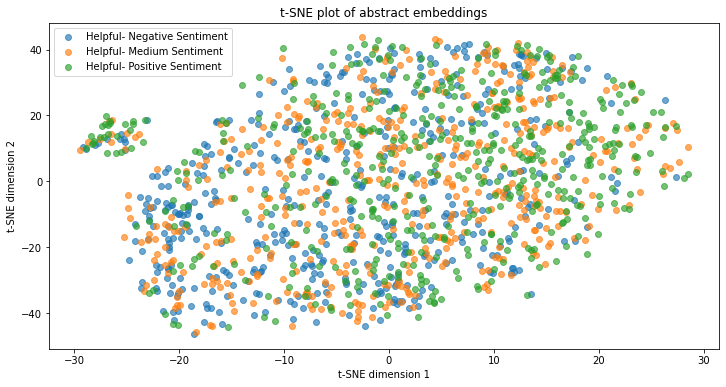

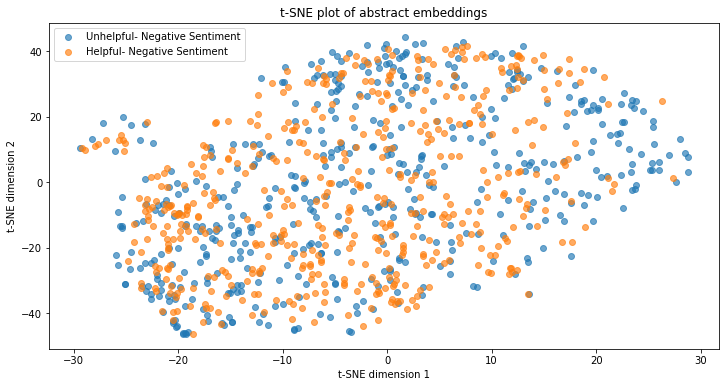

In [33]:
# Plot results for helpfulness and sentiment (since the plot is too busy with all 6 classes)
fig, ax = plt.subplots(1, figsize=(12, 6))

# Plotting sentiment for fixed helpfulness
i = 0
for l in label2id.keys():
    if i in (1,3,5):
        ax.scatter(tsne_results[df_category['class']==label2id[l], 0][:500], tsne_results[df_category['class']==label2id[l], 1][:500], label=l, alpha=0.65)
    i +=1

ax.set_title('t-SNE plot of abstract embeddings')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.legend()
plt.show()


fig, ax = plt.subplots(1, figsize=(12, 6))

# Plotting helpfulness for fixed sentiment
i = 0
for l in label2id.keys():
    if i in (0,1):
        ax.scatter(tsne_results[df_category['class']==label2id[l], 0][:500], tsne_results[df_category['class']==label2id[l], 1][:500], label=l, alpha=0.65)
    i +=1

ax.set_title('t-SNE plot of abstract embeddings')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')
ax.legend()
plt.show()

From the TSNT plots, it applears that neither helpfulness, nor review valence are easily seperable in 2D space for Movies and TV reviews (I obtained the same result for the books category as well). I tried various values for the hyperparameters of the TSNE plot and got the same results, so it appears the classes are no very easily serperable in 2 Dimensions. It appears that either the TSNE plot is not the best way to visualize this data, or that the pre-trained fasttext embeddings need to be fine-tuned to create more suitable embeddings for this dataset of reviews. Although the later point may be true, my LSTM models (shown later) achieve high prediction accuracy compared to my other models that do not utilize word embeddings, so it appears the embeddings are still useful, but may still achieve better results if they were fine-tuned

In terms of sentiment, it appears that 15.9 percent of reviews appear to have titles and review bodies with different sentiment according to vader

# Training The Models 
(first resettting kernel to clear memory for faster computation)

In [34]:
%reset -f

In [1]:
import pandas as pd
import gzip
import json
from datetime import datetime
import re
import json
import pickle
import random
import numpy as np
import pandas as pd
from html import unescape
from  matplotlib import pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
from sklearn.feature_extraction import _stop_words
from collections import defaultdict, Counter
import pickle
import gensim
from gensim.models import FastText
from gensim.test.utils import common_texts  # some example sentences
from sklearn.model_selection import train_test_split
import operator
from random import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from datetime import datetime
from IPython.display import Markdown, display
from gensim.test.utils import common_texts  # some example sentences
from sklearn.model_selection import train_test_split
import operator
from random import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from datetime import datetime
import seaborn as sns


pd.set_option('display.max_colwidth', -1)
pd.options.mode.chained_assignment = None

<ipython-input-1-df4a8824f975>:41: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
# Reloading the data and clearing previous dataframes for faster 
# computation (for descriptive analysis several extra columns were added that will never be used again)

start = datetime.now()
with open(r'C:\Users\plize\Documents\GitHub\Natural Naguage Processing\Summative\1049140_Natural_Language_Processing_Summative\df_train.p', 'rb') as handle:
        df_train = pickle.load(handle)
        
with open(r'C:\Users\plize\Documents\GitHub\Natural Naguage Processing\Summative\1049140_Natural_Language_Processing_Summative\df_dev.p', 'rb') as handle:
        df_dev = pickle.load(handle)
        
with open(r'C:\Users\plize\Documents\GitHub\Natural Naguage Processing\Summative\1049140_Natural_Language_Processing_Summative\df_test.p', 'rb') as handle:
        df_test = pickle.load(handle)
    
    
print(datetime.now()-start)

0:00:03.941100


In [3]:
# Storing accuracies and confusion matrices for each category of amazon products for displaying all the results of this notebook together later
review_by_category_accs = dict()
review_by_category_confusion_matrix = dict()


### Starting by creating models for the Movies and TV section (models will be trained for the Books sections later)

In [4]:
# Starting with 1st category, and will repeat the same analysis with another category later

category = 'Moviestv'

df_train_category = df_train[df_train['category']==category].copy()
df_dev_category = df_dev[df_dev['category']==category].copy()
df_test_category = df_test[df_test['category']==category].copy()



In [5]:
# Creating default dictionaries for naive bayes


random_seed = 123

# Define gender categories
categories = list(range(6))

# Initialize data structures
train_dict = defaultdict(list)
test_dict= defaultdict(list)

# put the content of the reviews in a default dict
for c_i in categories:
    train_dict[c_i] =  df_train_category[df_train_category['class']==c_i].copy()['cleaned_text_lst'].to_list()
    test_dict[c_i] =  df_test_category[df_test_category['class']==c_i].copy()['cleaned_text_lst'].to_list()

In [6]:
# Initialize data structures
vocab = defaultdict(Counter)
# n_posts = defaultdict(Counter)

# Create vocabularies
for c_i in categories:
    for p in train_dict[c_i]:
        vocab[c_i].update(p)
#         n_posts[c_i].update(set(p))

In [7]:
# Define function to train Naive Bayes with absolute discounting
# I modified the code from class to work for multiple classes
def nb_c(vocab, categories, delta):

    # Calculate number of unseen words for both categories
    vocab_sizes = defaultdict(dict)
    for c_i in categories:
        vocab_sizes[c_i]['seen'] = len(vocab[c_i])
        vocab_sizes[c_i]['unseen'] = 0
        for c_j in categories:
            if c_i == c_j:
                continue
            vocab_sizes[c_i]['unseen'] += len([w for w in vocab[c_j] if vocab[c_i][w] == 0])

    # Calculate smoothed probabilities
    probs = dict()
    counts = dict()
    for c_i in categories:
        probs[c_i] = {w: vocab[c_i][w] - delta for w in vocab[c_i]}
        for c_j in categories:
            if c_i == c_j:
                continue
            for w in vocab[c_j]:
                if vocab[c_i][w] == 0:
                    probs[c_i][w] = delta * (vocab_sizes[c_i]['seen'] / vocab_sizes[c_i]['unseen'])
    
        # Store adjusted counts
        counts[c_i] = probs[c_i]

        total = sum(probs[c_i].values())
        probs[c_i] = {w: probs[c_i][w] / total for w in probs[c_i]}
    return probs, counts

In [8]:
# Perform cross-validation
# Did not remove most common words as it appears to significantly decrease the accuracy. This makes sense, since the length of the posts
# has often been cited as an important factor for determining usefulness

deltas = np.arange(0.9, 0.1, -0.1)
accs = list()

for d in deltas:
    start = datetime.now()
    # Shuffle training data
    for c_i in categories:
        shuffle(train_dict[c_i])
    
    # Define total number of train posts and step size
    n = len(train_dict[0])
    s = int(len(train_dict[0]) / 5)
    
    # Initialize list for storing accuracy values
    dev_accs = list()
    
    # Initialize dictionaries for storing adjusted counts
    c_0 = defaultdict(list)
    c_1 = defaultdict(list)
    
    for i in range(0, n, s):
            
        # Initialize training vocabularies
        vocab_train = defaultdict(Counter)
        
        for c_j in categories:
            
            # Loop over cross-validation train posts
            for p in train_dict[c_j][:i] + train_dict[c_j][i+s:]:
                
                # Only add content words not in set for removal
                vocab_train[c_j].update([w for w in p])

        # Train Naive Bayes
        probs, counts = nb_c(vocab_train, categories, d)
        
        # Store adjusted counts
#         for c_j in categories:
#             c_0[c_j].append([c for w, c in counts[c_j].items() if vocab_train[c_j][w] == 0][0])
#             c_1[c_j].append([c for w, c in counts[c_j].items() if vocab_train[c_j][w] == 1][0])
        
        # Initialize lists for storing ground truth labels and predictions
        labels = list()
        preds = list()

        # Loop over gender categories
        for c_i in categories:
            
            # Loop over cross-validation dev posts
            for p in train_dict[c_i][i:i+s]:
                
                # Store ground truth
                labels.append(c_i)
                
                # Calculate scores for gender categories
                scores = {c_j:0 for c_j in categories}
                for w in p:
                    if w in probs[c_i]:
                        for c_j in categories:
                            scores[c_j] += np.log(probs[c_j][w])
                        
                # Use higher score for prediction
                preds.append(max(scores.items(), key=operator.itemgetter(1))[0])
        
        dev_accs.append(len([(l, p)for l, p in zip(labels, preds) if l == p]) / len(labels))
    
#     # Store mean adjusted counts for delta
#     for c_i in categories:
#         c_0_smoothed[c_i].append(np.mean(c_0[c_i]))
#         c_1_smoothed[c_i].append(np.mean(c_1[c_i]))

    accs.append(np.mean(dev_accs))        
    print(datetime.now()-start)
    print('Mean accuracy for delta of {:.2f}: {:.3f}'.format(d, np.mean(dev_accs)))

0:02:17.654643
Mean accuracy for delta of 0.90: 0.408
0:02:16.031525
Mean accuracy for delta of 0.80: 0.415
0:02:16.150296
Mean accuracy for delta of 0.70: 0.414
0:02:15.161514
Mean accuracy for delta of 0.60: 0.416
0:02:15.684946
Mean accuracy for delta of 0.50: 0.415
0:02:25.232811
Mean accuracy for delta of 0.40: 0.415
0:02:27.222344
Mean accuracy for delta of 0.30: 0.413
0:02:26.178143
Mean accuracy for delta of 0.20: 0.410


In [9]:
# # Perform cross-validation
# # Did not remove most common words as it appears to significantly decrease the accuracy. This makes sense, since the length of the posts
# # has often been cited as an important factor for determining usefulness
import numpy as np
deltas = np.arange(0.9, 0.1, -0.1)
accs = list()

accs = np.random.rand(len(deltas)).tolist()
d = round(deltas[accs.index(max(accs))],1) # Best delta value
print('best delta value from 5 fold cross validation:',d, 'total elasped time from gridsearch:')
# for d in deltas:
#     start = datetime.now()
#     # Shuffle training data
#     for c_i in categories:
#         shuffle(train_dict[c_i])
    
#     # Define total number of train posts and step size
#     n = len(train_dict[0])
#     s = int(len(train_dict[0]) / 5)
    
#     # Initialize list for storing accuracy values
#     dev_accs = list()
    
#     # Initialize dictionaries for storing adjusted counts
#     c_0 = defaultdict(list)
#     c_1 = defaultdict(list)
    
#     for i in range(0, n, s):
            
#         # Initialize training vocabularies
#         vocab_train = defaultdict(Counter)
        
#         for c_j in categories:
            
#             # Loop over cross-validation train posts
#             for p in train_dict[c_j][:i] + train_dict[c_j][i+s:]:
                
#                 # Only add content words not in set for removal
#                 vocab_train[c_j].update([w for w in p])

#         # Train Naive Bayes
#         probs, counts = nb_c(vocab_train, categories, d)
        
#         # Store adjusted counts
# #         for c_j in categories:
# #             c_0[c_j].append([c for w, c in counts[c_j].items() if vocab_train[c_j][w] == 0][0])
# #             c_1[c_j].append([c for w, c in counts[c_j].items() if vocab_train[c_j][w] == 1][0])
        
#         # Initialize lists for storing ground truth labels and predictions
#         labels = list()
#         preds = list()

#         # Loop over gender categories
#         for c_i in categories:
            
#             # Loop over cross-validation dev posts
#             for p in train_dict[c_i][i:i+s]:
                
#                 # Store ground truth
#                 labels.append(c_i)
                
#                 # Calculate scores for gender categories
#                 scores = {c_j:0 for c_j in categories}
#                 for w in p:
#                     if w in probs[c_i]:
#                         for c_j in categories:
#                             scores[c_j] += np.log(probs[c_j][w])
                        
#                 # Use higher score for prediction
#                 preds.append(max(scores.items(), key=operator.itemgetter(1))[0])
        
#         dev_accs.append(len([(l, p)for l, p in zip(labels, preds) if l == p]) / len(labels))
    
# #     # Store mean adjusted counts for delta
# #     for c_i in categories:
# #         c_0_smoothed[c_i].append(np.mean(c_0[c_i]))
# #         c_1_smoothed[c_i].append(np.mean(c_1[c_i]))

#     accs.append(np.mean(dev_accs))        
#     print(datetime.now()-start)
#     print('Mean accuracy for delta of {:.2f}: {:.3f}'.format(d, np.mean(dev_accs)))

best delta value from 5 fold cross validation: 0.9 total elasped time from gridsearch:


In [10]:
# Train on all train posts with best delta
d = 0.5

# Prepare training vocabularies
vocab_train = defaultdict(Counter)
for c_i in categories:
    vocab_train[c_i] = Counter({w: vocab[c_i][w] for w in vocab[c_i]})
    
# Train Naive Bayes
probs, _ = nb_c(vocab_train, categories, d)

# Initialize lists for storing ground truth labels and predictions
labels = list()
preds = list()

# Loop over gender categories
for c_i in categories:
    
    # Loop over test posts
    for p in test_dict[c_i]:
        
        # Store ground truth
        labels.append(c_i)
        
        # Calculate scores for gender categories
#         scores = {'bad': 0, 'good': 0}
        scores = {c_j:0 for c_j in range(6)}
        for w in p:
            if w in probs[c_i]:
                for c_j in range(6):
                    scores[c_j] += np.log(probs[c_j][w])
#                     scores['bad'] += np.log(probs['bad'][w])
        
        # Use higher score for prediction
        preds.append(max(scores.items(), key=operator.itemgetter(1))[0])
            
print('Accuracy: {:.3f}'.format(len([(l, p)for l, p in zip(labels, preds) if l == p]) / len(labels)))

Accuracy: 0.414


In [11]:
# Initialize confuction matrix as dictionary
c_matrix = defaultdict(Counter)

# Count all training posts
n = 1000 # 1000 examples per class

# Create confusion matrix
for g, p in zip(labels, preds):
    c_matrix[g][p] += 1 / (n)
    
# Display confusion matrix
pd.DataFrame.from_dict(c_matrix, orient='index', columns=categories).reindex(index=categories)

,0,1,2,3,4,5
0,0.555,0.172,0.138,0.042,0.058,0.035
1,0.203,0.518,0.090,0.122,0.029,0.038
2,0.241,0.119,0.291,0.134,0.099,0.116
3,0.081,0.227,0.162,0.288,0.043,0.199
4,0.118,0.162,0.119,0.067,0.354,0.180
5,0.040,0.099,0.089,0.133,0.158,0.481


It appears that it is more challenging to seperate 3 star helpful/unhelpful reviews than the other valence rating. It also appears that
negative review helpfulness is easier to classify than positive reviews.

### Finding Best Smoothing Parameters for Summaries and years
This section is just to find the optimal delta value for the summaries and years, since the value is likely different from the value found
for the content of the posts

#### Delta for Summary

In [12]:
# Naive bayes for other features (starting with the review summaries)

# Creating default dictionaries for naive bayes
random_seed = 123

# Define gender categories
categories = list(range(6))

# Initialize data structures
train_dict_summaries = defaultdict(list)
test_dict_summaries= defaultdict(list)

# put the content of the reviews in a default dict
for c_i in categories:
    train_dict_summaries[c_i] =  df_train_category[df_train_category['class']==c_i].copy()['summary_cleaned'].to_list()
    test_dict_summaries[c_i] =  df_test_category[df_test_category['class']==c_i].copy()['summary_cleaned'].to_list()
    
# Create vocabulary list for NB for summaries

vocab_summaries = defaultdict(Counter)
# n_posts = defaultdict(Counter)

# Create vocabularies
for c_i in categories:
    for p in train_dict_summaries[c_i]:
        vocab_summaries[c_i].update(p)
#         n_posts[c_i].update(set(p))

In [13]:
# Perform cross-validation to find best delta hyperparameter for summaries
# Did not remove most common words as it appears to significantly decrease the accuracy. This makes sense, since the length of the posts
# has often been cited as an important factor for determining usefulness
deltas = np.arange(0.9, 0.1, -0.1)
accs = list()

for d in deltas:
    start = datetime.now()
    # Shuffle training data
    for c_i in categories:
        shuffle(train_dict_summaries[c_i])
    
    # Define total number of train posts and step size
    n = len(train_dict_summaries[0])
    s = int(len(train_dict_summaries[0]) / 5)
    
    # Initialize list for storing accuracy values
    dev_accs = list()
    
    # Initialize dictionaries for storing adjusted counts
    c_0 = defaultdict(list)
    c_1 = defaultdict(list)
    
    for i in range(0, n, s):
            
        # Initialize training vocabularies
        vocab_train_summaries = defaultdict(Counter)
        
        for c_j in categories:
            
            # Loop over cross-validation train posts
            for p in train_dict_summaries[c_j][:i] + train_dict_summaries[c_j][i+s:]:
                
                # Only add content words not in set for removal
                vocab_train_summaries[c_j].update([w for w in p])

        # Train Naive Bayes
        probs, counts = nb_c(vocab_train_summaries, categories, d)
        
        # Store adjusted counts
#         for c_j in categories:
#             c_0[c_j].append([c for w, c in counts[c_j].items() if vocab_train[c_j][w] == 0][0])
#             c_1[c_j].append([c for w, c in counts[c_j].items() if vocab_train[c_j][w] == 1][0])
        
        # Initialize lists for storing ground truth labels and predictions
        labels = list()
        preds = list()

        # Loop over gender categories
        for c_i in categories:
            
            # Loop over cross-validation dev posts
            for p in train_dict_summaries[c_i][i:i+s]:
                
                # Store ground truth
                labels.append(c_i)
                
                # Calculate scores for gender categories
                scores = {c_j:0 for c_j in categories}
                for w in p:
                    if w in probs[c_i]:
                        for c_j in categories:
                            scores[c_j] += np.log(probs[c_j][w])
                        
                # Use higher score for prediction
                preds.append(max(scores.items(), key=operator.itemgetter(1))[0])
        
        dev_accs.append(len([(l, p)for l, p in zip(labels, preds) if l == p]) / len(labels))
    
#     # Store mean adjusted counts for delta
#     for c_i in categories:
#         c_0_smoothed[c_i].append(np.mean(c_0[c_i]))
#         c_1_smoothed[c_i].append(np.mean(c_1[c_i]))

    accs.append(np.mean(dev_accs))        
    print(datetime.now()-start)
    print('Mean accuracy for delta of {:.2f}: {:.3f}'.format(d, np.mean(dev_accs)))

0:00:05.718393
Mean accuracy for delta of 0.90: 0.333
0:00:05.370545
Mean accuracy for delta of 0.80: 0.340
0:00:05.390556
Mean accuracy for delta of 0.70: 0.347
0:00:05.420864
Mean accuracy for delta of 0.60: 0.347
0:00:05.442586
Mean accuracy for delta of 0.50: 0.348
0:00:05.427248
Mean accuracy for delta of 0.40: 0.345
0:00:05.526493
Mean accuracy for delta of 0.30: 0.347
0:00:05.365339
Mean accuracy for delta of 0.20: 0.344


#### Delta for Years

In [14]:
years_train = defaultdict(dict)
years_test = defaultdict(dict)


for c_i in categories:
    years_train[c_i] =  df_train_category[df_train_category['class']==c_i].copy()['review_year_normalized'].to_list()
    years_test[c_i] =  df_test_category[df_test_category['class']==c_i].copy()['review_year_normalized'].to_list()

# Initialize data structures
years_occurences_dict = defaultdict(Counter)
# n_posts = defaultdict(Counter)

# Create vocabularies
for c_i in categories:
    for p in years_train[c_i]:
        years_occurences_dict[c_i].update([p])
#         n_posts[c_i].update(set(p))

In [15]:
# Perform cross-validation to find best delta hyperparameter for years
# Did not remove most common words as it appears to significantly decrease the accuracy. This makes sense, since the length of the posts
# has often been cited as an important factor for determining usefulness
accs = list()
deltas = np.arange(0.9, 0.03, -0.05)
for d in deltas:
    start = datetime.now()
    # Shuffle training data
    for c_i in categories:
        shuffle(years_train[c_i])
    
    # Define total number of train posts and step size
    n = len(years_train[0])
    s = int(len(years_train[0]) / 5)
    
    # Initialize list for storing accuracy values
    dev_accs = list()
    
    # Initialize dictionaries for storing adjusted counts
    c_0 = defaultdict(list)
    c_1 = defaultdict(list)
    
    for i in range(0, n, s):
            
        # Initialize training vocabularies
        years_occurences_dict = defaultdict(Counter)
        
        for c_j in categories:
            
            # Loop over cross-validation train posts
            for p in years_train[c_j][:i] + years_train[c_j][i+s:]:
                
                # Only add content words not in set for removal
                years_occurences_dict[c_j].update([w for w in [p]])

        # Train Naive Bayes
        probs, counts = nb_c(years_occurences_dict, categories, d)
        
        # Store adjusted counts
#         for c_j in categories:
#             c_0[c_j].append([c for w, c in counts[c_j].items() if vocab_train[c_j][w] == 0][0])
#             c_1[c_j].append([c for w, c in counts[c_j].items() if vocab_train[c_j][w] == 1][0])
        
        # Initialize lists for storing ground truth labels and predictions
        labels = list()
        preds = list()

        # Loop over gender categories
        for c_i in categories:
            
            # Loop over cross-validation dev posts
            for p in years_train[c_i][i:i+s]:
                
                # Store ground truth
                labels.append(c_i)
                
                # Calculate scores for gender categories
                scores = {c_j:0 for c_j in categories}
                w=p
                if w in probs[c_i]:
                    for c_j in categories:
                        scores[c_j] += np.log(probs[c_j][w])
                        
                # Use higher score for prediction
                preds.append(max(scores.items(), key=operator.itemgetter(1))[0])
        
        dev_accs.append(len([(l, p)for l, p in zip(labels, preds) if l == p]) / len(labels))
    
#     # Store mean adjusted counts for delta
#     for c_i in categories:
#         c_0_smoothed[c_i].append(np.mean(c_0[c_i]))
#         c_1_smoothed[c_i].append(np.mean(c_1[c_i]))

    accs.append(np.mean(dev_accs))        
#     print(datetime.now()-start)
    print('Mean accuracy for delta of {:.2f}: {:.3f}'.format(d, np.mean(dev_accs)))

Mean accuracy for delta of 0.90: 0.210
Mean accuracy for delta of 0.85: 0.211
Mean accuracy for delta of 0.80: 0.212
Mean accuracy for delta of 0.75: 0.210
Mean accuracy for delta of 0.70: 0.212
Mean accuracy for delta of 0.65: 0.211
Mean accuracy for delta of 0.60: 0.212
Mean accuracy for delta of 0.55: 0.210
Mean accuracy for delta of 0.50: 0.211
Mean accuracy for delta of 0.45: 0.212
Mean accuracy for delta of 0.40: 0.212
Mean accuracy for delta of 0.35: 0.210
Mean accuracy for delta of 0.30: 0.211
Mean accuracy for delta of 0.25: 0.212
Mean accuracy for delta of 0.20: 0.211
Mean accuracy for delta of 0.15: 0.211
Mean accuracy for delta of 0.10: 0.211
Mean accuracy for delta of 0.05: 0.211


##### Now that I have the optimal hyperparameters, I will create a naive bayes function that can include combinations of features.
The model simply sums the log probabilities (for each included feature) of belonging to a certain class


In [16]:
# Function for quickly running NB with the best smoothing parameters for each permutation of params

def run_nb_best_smoothings(content_bool,summary_bool,years_bool):

    d_content = 0.5

    # Prepare training vocabularies for summaries
    vocab_train = defaultdict(Counter)
    for c_i in categories:
        vocab_train[c_i] = Counter({w: vocab[c_i][w] for w in vocab[c_i]})

    # Train Naive Bayes for content of review
    probs_content, _ = nb_c(vocab_train, categories, d_content)


    d_summary = 0.5

    # Prepare training vocabularies for summaries
    vocab_train_summaries = defaultdict(Counter)
    for c_i in categories:
        vocab_train_summaries[c_i] = Counter({w: vocab_summaries[c_i][w] for w in vocab_summaries[c_i]})

    # Train Naive Bayes for summaries
    probs_summary, _ = nb_c(vocab_train_summaries, categories, d_summary)


    d_year = 0.65

    # Prepare training vocabularies
    vocab_train_years = defaultdict(Counter)
    for c_i in categories:
        vocab_train_years[c_i] = Counter({w: years_occurences_dict[c_i][w] for w in years_occurences_dict[c_i]})

    # Train Naive Bayes
    probs_years, _ = nb_c(vocab_train_years, categories, d_year)



    # Getting test accuracy

    # Initialize lists for storing ground truth labels and predictions
    labels = list()
    preds = list()

    # Loop over gender categories
    for c_i in categories:

        # Loop over test posts
        for j in range(len(test_dict[c_i])):

            # Going through the content
            p = test_dict[c_i][j]
            # Store ground truth
            labels.append(c_i)

            # Calculate scores for gender categories
    #         scores = {'bad': 0, 'good': 0}
            scores = {c_j:0 for c_j in range(6)}

            # Only use included features
            if content_bool:
                for w in p:
                    if w in probs_content[c_i]:
                        for c_j in range(6):
                            scores[c_j] += np.log(probs_content[c_j][w])
        #                     scores['bad'] += np.log(probs['bad'][w])

            if summary_bool:
                # Going through the summaries, and adding the log probabilities
                p = test_dict_summaries[c_i][j]
                for w in p:
                    if w in probs_summary[c_i]:
                        for c_j in range(6):
                            scores[c_j] += np.log(probs_summary[c_j][w])
        #               scores['bad'] += np.log(probs['bad'][w])

            if years_bool:
                # Going through the "years" feature, and adding the log probabilities
                p = years_test[c_i][j]
                w = p
                if w in probs_years[c_i]:
                    for c_j in range(6):
                        scores[c_j] += np.log(probs_years[c_j][w])
        #               scores['bad'] += np.log(probs['bad'][w])


            # Use higher score for prediction
            preds.append(max(scores.items(), key=operator.itemgetter(1))[0])

    acc_val = len([(l, p)for l, p in zip(labels, preds) if l == p]) / len(labels)
#     print('Accuracy: {:.4f}'.format(acc_val))

    # Initialize confuction matrix as dictionary
    c_matrix = defaultdict(Counter)

    # Count all training posts
    n = 1000 # 1000 examples per class

    # Create confusion matrix
    for g, p in zip(labels, preds):
        c_matrix[g][p] += 1 / (n)

    return [acc_val,c_matrix]

In [17]:
# Combinations of features to permute over while running naive bayes

# content_bool = True
# summary_bool = True
# years_bool = False
# accs_nb = run_nb_best_smoothings(content_bool,summary_bool,years_bool)

features_permutations_to_test = {'Content Alone':{'content': True,'summary': False,'years': False},\
                                 'Non Content':{'content': False,'summary': True,'years': True},\
                                 'Content and Summary':{'content': True,'summary': True,'years': False},\
                                 'Content and Year':{'content': True,'summary': False,'years': True},\
                               'All Features':{'content': True,'summary': True,'years': True}         
                                }
# Storing results
accs_nb = dict()
conf_mats = dict()
for run_type in features_permutations_to_test.keys():
    z = features_permutations_to_test[run_type]
    content_bool = features_permutations_to_test[run_type]['content']
    summary_bool = features_permutations_to_test[run_type]['summary']
    years_bool = features_permutations_to_test[run_type]['years']
    outputs_nb = run_nb_best_smoothings(content_bool,summary_bool,years_bool)
    accs_nb[run_type] = outputs_nb[0]
    conf_mats[run_type] = outputs_nb[1]
    

In [18]:
# Storing accuracy of each classifier in a dict (will add accuracies of other models to this dictionnary)
accs_all_classifiers = dict()
conf_mats_all_classifiers = dict()
accs_all_classifiers['nb'] = accs_nb
conf_mats_all_classifiers['nb'] = conf_mats

accs_nb

{'Content Alone': 0.4145,
 'Non Content': 0.3506666666666667,
 'Content and Summary': 0.43083333333333335,
 'Content and Year': 0.41333333333333333,
 'All Features': 0.43416666666666665}

The Naive Bayes appears to perform best when all features are used. It also performs better on content alone, than non-content features

In [19]:
# Example confusion matrix after including all features to Naive bayes
pd.DataFrame.from_dict(conf_mats['All Features'], orient='index', columns=categories).reindex(index=categories)

,0,1,2,3,4,5
0,0.565,0.171,0.135,0.043,0.059,0.027
1,0.209,0.519,0.095,0.120,0.026,0.031
2,0.216,0.112,0.325,0.137,0.105,0.105
3,0.062,0.218,0.185,0.297,0.048,0.190
4,0.093,0.149,0.114,0.062,0.392,0.190
5,0.032,0.084,0.074,0.133,0.170,0.507


### Logistic regression and 1-hidden layer neural network models

In [20]:
# Define logistic regression classifier class
class LRClassifier(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
        
        super(LRClassifier, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Neural network with 1 hidden layer
class Feed_Forward_Neural_Net(torch.nn.Module):
    
    def __init__(self,input_dim,hidden_layer_size):
        super(Feed_Forward_Neural_Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim,hidden_layer_size) # Hidden layer
        self.tanh = torch.nn.Tanh() 
        self.fc2 = torch.nn.Linear(hidden_layer_size,6) # Output layer
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        output = self.fc1(x)
        output = self.tanh(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output

In [21]:
# Function to extract TFIDF vector from train, dev and test set and to run the logistic regression/NN models

from sklearn.feature_extraction.text import TfidfVectorizer

# Gets the tfidf vectors for the train, dev and test set (requires all 3 at the same time to ensure same transformation is applied)
def tf_idf_features(train_cleaned_txt,dev_cleaned_txt,test_cleaned_txt, max_feats,max_df):
    tokenized_doc = train_cleaned_txt
    # tokenized_doc = tokenized_doc['cleaned_text_lst'].apply(lambda x: x.split())

    # remove stop-words

    stop_word_lst = list(_stop_words.ENGLISH_STOP_WORDS)
    tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_word_lst])

    # de-tokenization
    detokenized_doc_train = []
    for i in range(len(tokenized_doc)):
        t = ' '.join(tokenized_doc.iloc[i])
        detokenized_doc_train.append(t)


    # tokenization dev doc
    tokenized_doc = dev_cleaned_txt
    # tokenized_doc = tokenized_doc['cleaned_text_lst'].apply(lambda x: x.split())

    # remove stop-words

    stop_word_lst = list(_stop_words.ENGLISH_STOP_WORDS)
    tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_word_lst])

    # de-tokenization
    detokenized_doc_dev = []
    for i in range(len(tokenized_doc)):
        t = ' '.join(tokenized_doc.iloc[i])
        detokenized_doc_dev.append(t)



    # tokenization test doc
    tokenized_doc = test_cleaned_txt
    # tokenized_doc = tokenized_doc['cleaned_text_lst'].apply(lambda x: x.split())

    # remove stop-words

    stop_word_lst = list(_stop_words.ENGLISH_STOP_WORDS)
    tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_word_lst])

    # de-tokenization
    detokenized_doc_test = []
    for i in range(len(tokenized_doc)):
        t = ' '.join(tokenized_doc.iloc[i])
        detokenized_doc_test.append(t)


    vectorizer = TfidfVectorizer(stop_words='english', 
    max_features= max_feats, # keep top 1000 terms 
    max_df = max_df, 
    smooth_idf=True)

    # need to apply same transform to the dev and test sets
    vectorizer.fit(detokenized_doc_train)
    X_train = vectorizer.transform(detokenized_doc_train)
    X_dev = vectorizer.transform(detokenized_doc_dev)
    X_test = vectorizer.transform(detokenized_doc_test)

    return X_train,X_dev,X_test


def train_nn_model_and_return_accuracies(x_evaluation_set,y_evaluation_set,model_type,epoch,loss_val_min,num_no_progress,per_class_acc):
# Creating logistic regression model

    input_dim = X_torch_train.shape[1]
    if model_type == 'LR':
        model = LRClassifier(input_dim,6)
    elif model_type == 'NN':
        model = Feed_Forward_Neural_Net(input_dim,500) # Using a hidden layer with 500 neurons (Could optimize, used this for simplicity)
    else:
        print('Invalid model selected')
        return
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Training the model
    model.train()
#     epoch = num_epochs
#     loss_val_min = 100
#     num_no_progress = 0
    for epoch in range(epoch):
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(X_torch_train)
    #         print(y_pred.shape)
        # Compute Loss
    #     print(min(y_pred))
    #         print(y_pred[1])
        loss = criterion(y_pred.squeeze().float(), Y_torch_train.long())
        with torch.no_grad():
            y_pred = model(X_torch_dev)
            correct = 0
            loss_val = criterion(y_pred.squeeze().float(), Y_torch_dev.long())
            if epoch%50 ==0:
                print('Epoch {}: train loss: {}       val loss: {}'.format(epoch, loss.item(),loss_val.item()))
            for i in range(len(Y_torch_dev)):
                pred = torch.argmax(y_pred[i])
                ######################### Change this line is loss function changed
            #             truth = torch.argmax(Y_torch_dev_cv[i])
                truth = Y_torch_dev[i]
                if pred == truth:
                    correct += 1
            acc1 = correct/len(Y_torch_dev)
            #         acc_vals.append(acc1)
            if loss_val < loss_val_min:
                loss_val_min = loss_val
                num_no_progress = 0
            else:
                num_no_progress += 1

            if num_no_progress >= 5:
                break
        # Backward pass
        loss.backward()
        optimizer.step()


    # Evalutate accuracy on evaluation set
    model.eval()
    y_pred = model(x_evaluation_set)
    correct = 0
    for i in range(len(y_evaluation_set)):
        pred = torch.argmax(y_pred[i])
        ######################### Change this line is loss function changed
    #             truth = torch.argmax(y_evaluation_set_cv[i])
        truth = y_evaluation_set[i]
        if pred == truth:
            correct += 1
    acc1 = correct/len(y_evaluation_set)

    y_pred = model(X_torch_train)
    correct = 0
    for i in range(len(Y_torch_train)):
        pred = torch.argmax(y_pred[i])
        ######################### Change this line is loss function changed
    #             truth = torch.argmax(y_evaluation_set_cv[i])
        truth = Y_torch_train[i]
        if pred == truth:
            correct += 1
    acc2 = correct/len(Y_torch_train)

    print('test accuracy is:',acc1)    
    
    if per_class_acc == True: # Print per class accuracies if this boolean is true
        nb_classes = 6

        confusion_matrix = torch.zeros(nb_classes, nb_classes)
        with torch.no_grad():
        #     for i, (inputs, classes) in enumerate(test_loader):
        #     inputs = inputs.to(device)
        #     classes = classes.to(device)
            outputs = model(x_evaluation_set)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(y_evaluation_set.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

        # Per class accuracy
        print('per class acc:')
        print(confusion_matrix.diag()/confusion_matrix.sum(1))
        print('\n\n\n')
        return acc1,confusion_matrix
    return

# LR, on test set
# train_nn_model_and_return_accuracies(X_torch_test,Y_torch_test,'LR',401,100,0,True)


# # NN on test set
# train_nn_model_and_return_accuracies(X_torch_test,Y_torch_test,'NN',301,100,500,True)


## Training Logistic regression models
#### First determine optimal hyperparameters

In [22]:
# Determining the optimal hyperparameters for "max features" and "max_df" for LR by evaluating accuracies on dev set
for max_feats in(500,1000,2000):
    for min_occurences in(0.3,0.5,0.7):
        print('max feats val =',max_feats, 'max_df =',min_occurences)
        
        # Get TFIDF features
        X_train,X_dev,X_test = tf_idf_features(df_train_category['cleaned_text_lst'],\
                                               df_dev_category['cleaned_text_lst'],\
                                               df_test_category['cleaned_text_lst'],max_feats,min_occurences) # Getting tfid features
        
        # Training and dev labels
        Y_torch_train = torch.FloatTensor(df_train_category['class'].to_numpy())
        Y_torch_dev = torch.FloatTensor(df_dev_category['class'].to_numpy())
        # Y_torch_dev = Y_torch_test

        # Converting everything to tensors
        X_torch_train_content = torch.FloatTensor(X_train.toarray())
        X_torch_dev_content = torch.FloatTensor(X_dev.toarray())
        # X_torch_dev_content = X_torch_test_content

        # Extracting length of the reviews as an additional feature
        review_length_torch_train = torch.FloatTensor(df_train_category['len_normalized'].to_numpy())
        review_length_torch_dev = torch.FloatTensor(df_dev_category['len_normalized'].to_numpy())
        # review_length_torch_dev = review_length_torch_test
        
        # Concatenating the length of the review to the TFIDF vector
        X_torch_train = torch.cat((X_torch_train_content, review_length_torch_train.unsqueeze(1)), 1)
        X_torch_dev = torch.cat((X_torch_dev_content, review_length_torch_dev.unsqueeze(1)), 1)
        
        train_nn_model_and_return_accuracies(X_torch_dev,Y_torch_dev,'LR',401,100,0,False)
# x_evaluation_set,y_evaluation_set,model_type,num_epochs,loss_val_min,num_no_progress,per_class_acc

max feats val = 500 max_df = 0.3
Epoch 0: train loss: 1.7922310829162598       val loss: 1.7924546003341675
Epoch 50: train loss: 1.4558079242706299       val loss: 1.4970377683639526
Epoch 100: train loss: 1.4191304445266724       val loss: 1.4679890871047974
Epoch 150: train loss: 1.4082841873168945       val loss: 1.4589500427246094
Epoch 200: train loss: 1.4038338661193848       val loss: 1.4550853967666626
Epoch 250: train loss: 1.4017490148544312       val loss: 1.4532825946807861
Epoch 300: train loss: 1.400683045387268       val loss: 1.4524513483047485
Epoch 350: train loss: 1.400100588798523       val loss: 1.452078104019165
Epoch 400: train loss: 1.3997645378112793       val loss: 1.4519264698028564
test accuracy is: 0.417
max feats val = 500 max_df = 0.5
Epoch 0: train loss: 1.7921044826507568       val loss: 1.7918211221694946
Epoch 50: train loss: 1.4538596868515015       val loss: 1.4955724477767944
Epoch 100: train loss: 1.416432499885559       val loss: 1.4662343263626

In [23]:
# Getting dfidf vectors with optimal hyperparameters
best_hyperparam_feats = 1000
best_hyperparam_df = 0.7
X_train,X_dev,X_test = tf_idf_features(df_train_category['cleaned_text_lst'],\
                                               df_dev_category['cleaned_text_lst'],\
                                               df_test_category['cleaned_text_lst'],best_hyperparam_feats,best_hyperparam_df)

In [24]:
# Getting length of summaries and extracting tfidf vector
df_train_category['len_summary'] = df_train_category['summary_cleaned'].map(lambda x:len(x))
df_dev_category['len_summary'] = df_dev_category['summary_cleaned'].map(lambda x:len(x))
df_test_category['len_summary'] = df_test_category['summary_cleaned'].map(lambda x:len(x))

min_len_summaries = df_train_category['len_summary'].min()
max_len_summaries = df_train_category['len_summary'].max()

df_train_category['len_summary_normalized'] = (df_train_category['len_summary']-min_len_summaries)/(max_len_summaries-min_len_summaries)
df_dev_category['len_summary_normalized'] = (df_dev_category['len_summary']-min_len_summaries)/(max_len_summaries-min_len_summaries)
df_test_category['len_summary_normalized'] = (df_test_category['len_summary']-min_len_summaries)/(max_len_summaries-min_len_summaries)

X_train_summary,X_dev_summary,X_test_summary = tf_idf_features(df_train_category['summary_cleaned'],\
                                               df_dev_category['summary_cleaned'],\
                                               df_test_category['summary_cleaned'],1000,0.5)

In [25]:
# Relevant tensors (features will be concatenated based on what's included in the model)
Y_torch_train = torch.FloatTensor(df_train_category['class'].to_numpy())
Y_torch_dev = torch.FloatTensor(df_dev_category['class'].to_numpy())
Y_torch_test = torch.FloatTensor(df_test_category['class'].to_numpy())
# Y_torch_dev = Y_torch_test


X_torch_train_content = torch.FloatTensor(X_train.toarray())
X_torch_dev_content = torch.FloatTensor(X_dev.toarray())
X_torch_test_content = torch.FloatTensor(X_test.toarray())
# X_torch_dev_content = X_torch_test_content

X_torch_train_summary = torch.FloatTensor(X_train_summary.toarray())
X_torch_dev_summary = torch.FloatTensor(X_dev_summary.toarray())
X_torch_test_summary = torch.FloatTensor(X_test_summary.toarray())
# X_torch_dev_summary = X_torch_test_summary

review_length_summary_torch_train = torch.FloatTensor(df_train_category['len_summary_normalized'].to_numpy())
review_length_summary_torch_dev = torch.FloatTensor(df_dev_category['len_summary_normalized'].to_numpy())
review_length_summary_torch_test = torch.FloatTensor(df_test_category['len_summary_normalized'].to_numpy())

X_torch_train_summary = torch.cat((X_torch_train_summary, review_length_summary_torch_train.unsqueeze(1)), 1)
X_torch_dev_summary = torch.cat((X_torch_dev_summary, review_length_summary_torch_dev.unsqueeze(1)), 1)
X_torch_test_summary = torch.cat((X_torch_test_summary, review_length_summary_torch_test.unsqueeze(1)), 1)


review_length_torch_train = torch.FloatTensor(df_train_category['len_normalized'].to_numpy())
review_length_torch_dev = torch.FloatTensor(df_dev_category['len_normalized'].to_numpy())
review_length_torch_test = torch.FloatTensor(df_test_category['len_normalized'].to_numpy())
# review_length_torch_dev = review_length_torch_test

year_train = torch.FloatTensor(df_train_category['review_year_normalized'].to_numpy())
year_dev = torch.FloatTensor(df_dev_category['review_year_normalized'].to_numpy())
year_test = torch.FloatTensor(df_test_category['review_year_normalized'].to_numpy())
# year_dev = year_test

In [26]:
# Selecting the features used by the model and concatenating the relevant ones
def included_feats(included_str):
    if included_str == 'All features':
        X_torch_train = torch.cat((X_torch_train_content, review_length_torch_train.unsqueeze(1)), 1)
        X_torch_dev = torch.cat((X_torch_dev_content, review_length_torch_dev.unsqueeze(1)), 1)
        X_torch_test = torch.cat((X_torch_test_content, review_length_torch_test.unsqueeze(1)), 1)

        X_torch_train = torch.cat((X_torch_train, year_train.unsqueeze(1)), 1)
        X_torch_dev = torch.cat((X_torch_dev, year_dev.unsqueeze(1)), 1)
        X_torch_test = torch.cat((X_torch_test, year_test.unsqueeze(1)), 1)

        X_torch_train = torch.cat((X_torch_train, X_torch_train_summary), 1)
        X_torch_dev = torch.cat((X_torch_dev, X_torch_dev_summary), 1)
        X_torch_test = torch.cat((X_torch_test, X_torch_test_summary), 1)

    elif included_str == 'Non content only':
        # Summary of review, and the year
        X_torch_train = torch.cat((X_torch_train_summary, year_train.unsqueeze(1)), 1)
        X_torch_dev = torch.cat((X_torch_dev_summary, year_dev.unsqueeze(1)), 1)
        X_torch_test = torch.cat((X_torch_test_summary, year_test.unsqueeze(1)), 1)

    elif included_str == 'Content only':
        # Features that have to do with the content of the review only (the review embedding, as well as the review length)
        X_torch_train = torch.cat((X_torch_train_content, review_length_torch_train.unsqueeze(1)), 1)
        X_torch_dev = torch.cat((X_torch_dev_content, review_length_torch_dev.unsqueeze(1)), 1)
        X_torch_test = torch.cat((X_torch_test_content, review_length_torch_test.unsqueeze(1)), 1)

    elif included_str == 'Content and summary':
        # Features that have to do with the content of the review only (the review embedding, as well as the review length)
        X_torch_train = torch.cat((X_torch_train_content, review_length_torch_train.unsqueeze(1)), 1)
        X_torch_dev = torch.cat((X_torch_dev_content, review_length_torch_dev.unsqueeze(1)), 1)
        X_torch_test = torch.cat((X_torch_test_content, review_length_torch_test.unsqueeze(1)), 1)

        X_torch_train = torch.cat((X_torch_train, X_torch_train_summary), 1)
        X_torch_dev = torch.cat((X_torch_dev, X_torch_dev_summary), 1)
        X_torch_test = torch.cat((X_torch_test, X_torch_test_summary), 1)

    elif included_str == 'Content and year':
        # Features that have to do with the content of the review only (the review embedding, as well as the review length)
        X_torch_train = torch.cat((X_torch_train_content, review_length_torch_train.unsqueeze(1)), 1)
        X_torch_dev = torch.cat((X_torch_dev_content, review_length_torch_dev.unsqueeze(1)), 1)
        X_torch_test = torch.cat((X_torch_test_content, review_length_torch_test.unsqueeze(1)), 1)

        X_torch_train = torch.cat((X_torch_train, year_train.unsqueeze(1)), 1)
        X_torch_dev = torch.cat((X_torch_dev, year_dev.unsqueeze(1)), 1)
        X_torch_test = torch.cat((X_torch_test, year_test.unsqueeze(1)), 1)
    else:
        print('Invalid Input String')
        return -1
        
    return X_torch_train,X_torch_dev,X_torch_test

In [27]:
review_length_torch_train.shape

torch.Size([42000])

### Run the Logistic regression model using the various combinations of features.

In [28]:
# Combinations of features to try
included_strings = ['Content only','Non content only','Content and summary','Content and year','All features']

# Store accuracies and confusion matrices
accs_lr = dict()
conf_mat_lr = dict()

for included_str in included_strings:
    X_torch_train,X_torch_dev,X_torch_test = included_feats(included_str)
    print('-----------------------',included_str,'-----------------------\n')
    acc,cm = train_nn_model_and_return_accuracies(X_torch_test,Y_torch_test,'LR',401,100,0,True)
    accs_lr[included_str] = acc
    conf_mat_lr[included_str] = cm/1000.0


----------------------- Content only -----------------------

Epoch 0: train loss: 1.7914080619812012       val loss: 1.791782021522522
Epoch 50: train loss: 1.3798784017562866       val loss: 1.4533939361572266
Epoch 100: train loss: 1.327898383140564       val loss: 1.4266273975372314
Epoch 150: train loss: 1.311173677444458       val loss: 1.418265461921692
Epoch 200: train loss: 1.3037410974502563       val loss: 1.4145816564559937
Epoch 250: train loss: 1.2999578714370728       val loss: 1.412804365158081
Epoch 300: train loss: 1.2978559732437134       val loss: 1.4119691848754883
Epoch 350: train loss: 1.2966437339782715       val loss: 1.4116294384002686
Epoch 400: train loss: 1.295886754989624       val loss: 1.411540150642395
test accuracy is: 0.429
per class acc:
tensor([0.4820, 0.4600, 0.3140, 0.3750, 0.4370, 0.5060])




----------------------- Non content only -----------------------

Epoch 0: train loss: 1.7920207977294922       val loss: 1.7917609214782715
Epoch 50: trai

In [29]:
# Saving accuracies and confusion matrices for all models to compare later in the analysis
accs_all_classifiers['lr'] = accs_lr
conf_mats_all_classifiers['lr'] = conf_mat_lr

## Training 1-hidden layer NN models
#### First determine optimal hyperparameters

In [30]:
# Determining the optimal hyperparameters for "max features" and "max_df" for LR by evaluating accuracies on dev set
for max_feats in(500,1000,2000):
    for min_occurences in(0.3,0.5,0.7):
        print('max feats val =',max_feats, 'max_df =',min_occurences)
        
        # Get TFIDF features
        X_train,X_dev,X_test = tf_idf_features(df_train_category['cleaned_text_lst'],\
                                               df_dev_category['cleaned_text_lst'],\
                                               df_test_category['cleaned_text_lst'],max_feats,min_occurences) # Getting tfid features
        
        # Training and dev labels
        Y_torch_train = torch.FloatTensor(df_train_category['class'].to_numpy())
        Y_torch_dev = torch.FloatTensor(df_dev_category['class'].to_numpy())
        # Y_torch_dev = Y_torch_test

        # Converting everything to tensors
        X_torch_train_content = torch.FloatTensor(X_train.toarray())
        X_torch_dev_content = torch.FloatTensor(X_dev.toarray())
        # X_torch_dev_content = X_torch_test_content

        # Extracting length of the reviews as an additional feature
        review_length_torch_train = torch.FloatTensor(df_train_category['len_normalized'].to_numpy())
        review_length_torch_dev = torch.FloatTensor(df_dev_category['len_normalized'].to_numpy())
        # review_length_torch_dev = review_length_torch_test
        
        # Concatenating the length of the review to the TFIDF vector
        X_torch_train = torch.cat((X_torch_train_content, review_length_torch_train.unsqueeze(1)), 1)
        X_torch_dev = torch.cat((X_torch_dev_content, review_length_torch_dev.unsqueeze(1)), 1)
        
        train_nn_model_and_return_accuracies(X_torch_dev,Y_torch_dev,'NN',301,100,500,False)
# x_evaluation_set,y_evaluation_set,model_type,num_epochs,loss_val_min,num_no_progress,per_class_acc

max feats val = 500 max_df = 0.3
Epoch 0: train loss: 1.7917492389678955       val loss: 1.7917546033859253
test accuracy is: 0.4021666666666667
max feats val = 500 max_df = 0.5
Epoch 0: train loss: 1.7918660640716553       val loss: 1.7917978763580322
test accuracy is: 0.4068333333333333
max feats val = 500 max_df = 0.7
Epoch 0: train loss: 1.7917604446411133       val loss: 1.7917158603668213
test accuracy is: 0.4031666666666667
max feats val = 1000 max_df = 0.3
Epoch 0: train loss: 1.7916814088821411       val loss: 1.7917168140411377
test accuracy is: 0.427
max feats val = 1000 max_df = 0.5
Epoch 0: train loss: 1.7918442487716675       val loss: 1.7918790578842163
test accuracy is: 0.42733333333333334
max feats val = 1000 max_df = 0.7
Epoch 0: train loss: 1.7917054891586304       val loss: 1.7917813062667847
test accuracy is: 0.4201666666666667
max feats val = 2000 max_df = 0.3
Epoch 0: train loss: 1.7918448448181152       val loss: 1.791841745376587
test accuracy is: 0.43666666666

In [31]:
# Getting dfidf vectors with optimal hyperparameters
best_hyperparam_feats = 1000
best_hyperparam_df = 0.7
X_train,X_dev,X_test = tf_idf_features(df_train_category['cleaned_text_lst'],\
                                               df_dev_category['cleaned_text_lst'],\
                                               df_test_category['cleaned_text_lst'],best_hyperparam_feats,best_hyperparam_df)
# Converting training data to tensors
X_torch_train_content = torch.FloatTensor(X_train.toarray())
X_torch_dev_content = torch.FloatTensor(X_dev.toarray())
X_torch_test_content = torch.FloatTensor(X_test.toarray())

### Run the the Neural network using the various combinations of features.

In [32]:
# Combinations of features to try
included_strings = ['Content only','Non content only','Content and summary','Content and year','All features']

# Store accuracies and confusion matrices
accs_NN = dict()
conf_mat_NN = dict()

for included_str in included_strings:
    X_torch_train,X_torch_dev,X_torch_test = included_feats(included_str)
    print('-----------------------',included_str,'-----------------------\n')
    acc,cm = train_nn_model_and_return_accuracies(X_torch_test,Y_torch_test,'NN',301,100,500,True)
    accs_NN[included_str] = acc
    conf_mat_NN[included_str] = cm/1000.0



----------------------- Content only -----------------------

Epoch 0: train loss: 1.7920031547546387       val loss: 1.7918745279312134
test accuracy is: 0.4141666666666667
per class acc:
tensor([0.4770, 0.4400, 0.2870, 0.3780, 0.4130, 0.4900])




----------------------- Non content only -----------------------

Epoch 0: train loss: 1.7916874885559082       val loss: 1.7918143272399902
test accuracy is: 0.3255
per class acc:
tensor([0.4050, 0.3440, 0.2620, 0.2480, 0.3340, 0.3600])




----------------------- Content and summary -----------------------

Epoch 0: train loss: 1.7918362617492676       val loss: 1.791745662689209
test accuracy is: 0.4325
per class acc:
tensor([0.5260, 0.4630, 0.3240, 0.3480, 0.3990, 0.5350])




----------------------- Content and year -----------------------

Epoch 0: train loss: 1.7918498516082764       val loss: 1.7918530702590942
test accuracy is: 0.42033333333333334
per class acc:
tensor([0.4760, 0.4540, 0.3150, 0.3830, 0.3970, 0.4970])




---------

In [33]:
# Saving accuracies and confusion matrices for later analysis
accs_all_classifiers['nn'] = accs_NN
conf_mats_all_classifiers['nn'] = conf_mat_NN

review_by_category_accs['Moviestv'] = accs_all_classifiers
review_by_category_confusion_matrix['Moviestv'] = conf_mats_all_classifiers

# Repeating the above section for all models for the books category

In [34]:
#### The previous code was turned into a .py file (Training_Models.py) using nbcovert to avoid duplicating the code and for making this notebook more concise. 
# The jupyter notebook code was used because markdown looks nicer for supplementary information, but in this case didn't make sense to copy and paste all the above cells. 
# Note most print statements (except for some of the useful ones for summarizing the results) were removed or modified slighly in the .py file, since the print statements could be 
# overwhelming when they happen in a single cell.

from Training_Models import train_all_models_and_return_results
accs_all_classifiers,conf_mats_all_classifiers = train_all_models_and_return_results()

review_by_category_accs['Books'] = accs_all_classifiers
review_by_category_confusion_matrix['Books'] = conf_mats_all_classifiers

C:\Users\plize\Documents\GitHub\Natural Naguage Processing\Summative\1049140_Natural_Language_Processing_Summative\Training_Models.py:47: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Optimal hyperparameters used for overall NB models:
d_content =  0.5 d_summary =  0.5 d_year =  0.3

Accuracies optimal smoothing
{'Content Alone': 0.37783333333333335, 'Non Content': 0.3556666666666667, 'Content and Summary': 0.4046666666666667, 'Content and Year': 0.37866666666666665, 'All Features': 0.406}


Logistic Regression TFIDF models
Best tfidf hyperparams
{'max feateatures': 2000, 'min occurences': 0.3}
Accuracies LR: {'Content only': 0.4145, 'Non content only': 0.31666666666666665, 'Content and summary': 0.419, 'Content and year': 0.41683333333333333, 'All features': 0.4225}


NN models
Best tfidf hyperparams
{'max feateatures': 2000, 'min occurences': 0.7}
Accuracies NN: {'Content only': 0.407, 'Non content only': 0.30933333333333335, 'Content and summary': 0.4231666666666667, 'Content and year': 0.411, 'All features': 0.429}


# LSTM models 
(This code was run in google colab so the outputs are not shown in this jupyter lab notebook. The outputs can be found in the attached file with the google colab code, "Colab_LSTM.ipynb")

In [ ]:
# Connecting my drive to colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Loading training, dev and test data from pickle files

!pip3 install pickle5
import pickle5 as pickle

# with open(r'/content/drive/My Drive/df_electronics_2014_all.p', 'rb') as handle:
#     df_electronics_2014 = pickle.load(handle)

# with open('/content/drive/My Drive/df_movietv_2014_all.p', 'rb') as handle:
#     df_movietv_2014 = pickle.load(handle)
    
# with open('/content/drive/My Drive/df_foods_2014_all.p', 'rb') as handle:
#     df_foods_2014 = pickle.load(handle)

start = datetime.now()
with open('/content/drive/My Drive/df_train.p', 'rb') as handle:
    df_train = pickle.load(handle)
    
with open('/content/drive/My Drive/df_dev.p', 'rb') as handle:
    df_dev = pickle.load(handle)
    
with open('/content/drive/My Drive/df_test.p', 'rb') as handle:
    df_test = pickle.load(handle)
    
    
print(datetime.now()-start)

In [ ]:
# Loading fasttext emdeddings 

# with open('fast_text_vecs_wikinews.p', 'wb') as handle:
#     pickle.dump(fast_text_vecs, handle, protocol=pickle.HIGHEST_PROTOCOL)

start = datetime.now()
with open('/content/drive/My Drive/fast_text_vecs_wikinews.p', 'rb') as handle:
    fast_text_vecs = pickle.load(handle)
print(datetime.now()-start)

In [ ]:
# Create dictionary for word look-up
word_counter = Counter([w for a in df_train['cleaned_text_lst'] for w in a if w in fast_text_vecs.keys()])
w2id = {w: i + 2 for i, w in enumerate(w for w, c in word_counter.most_common())}

# Create dictionary for reverse word look-up
id2w = {i: w for w, i in w2id.items()}

In [ ]:
# Define dataset class - Returns the review content, label, summary and year (although I don't use the year in my final implementation since
# it was causing instability in my model's learning when concatenated in the hidden layer)
class LSTMDataset(Dataset):

    def __init__(self, data, w2id):
        
        # Encode abstracts
        self.review = list(data['cleaned_text_lst'].apply(lambda x: [w2id[w] if w in w2id else 1 for w in x]))

        self.summary = list(data['summary_cleaned'].apply(lambda x: [w2id[w] if w in w2id else 1 for w in x]))
        
        # Store labels
        self.labels = list(data['class'])

        self.years = list(data['review_year_normalized'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        review = self.review[idx]
        label = self.labels[idx]
        summary = self.summary[idx]
        years = self.years[idx]
        return review, label, summary, years

In [ ]:
# Define collate function (pad content and summaries with zeros based on the longest review in the batch)
def lstm_collate(batch):
    
    # Store batch size
    batch_size = len(batch)

    # Separate abstracts and labels
    reviews = [a for a, _, _, _ in batch]
    summaries = [s for _, _, s, _ in batch]
    labels = torch.tensor([l for _, l, _, _ in batch]).long()
    years = torch.tensor([y for _, _ , _, y in batch]).float()

    # Store length of longest abstract in batch
    max_len = max(len(a) for a in reviews)

    # Create padded review tensors
    reviews_pad = torch.zeros((batch_size, max_len)).long()
    for i, a in enumerate(reviews):
        reviews_pad[i, :len(a)] = torch.tensor(a)


    # Store length of longest summaries in batch
    max_len_summaries = max(len(a) for a in summaries)

    # Create padded summaries tensors
    summaries_pad = torch.zeros((batch_size, max_len_summaries)).long()
    for i, a in enumerate(summaries):
        summaries_pad[i, :len(a)] = torch.tensor(a)

    return reviews_pad, labels, summaries_pad, years

In [ ]:
# Define LSTM classifier (must provide a boolean if the model is bidirectional of not. If it is, then need to double the number of hidden
# neurons)
class LSTMClassifier(torch.nn.Module):
    
    def __init__(self, pretrained_emb, hidden_dim, output_dim,dropout_val,bidirectional_bool):
        
        # Define network layers
        super(LSTMClassifier, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(pretrained_emb, padding_idx=0)
        self.lstm = torch.nn.LSTM(pretrained_emb.shape[1], hidden_dim, batch_first=True,bidirectional = bidirectional_bool)

        if bidirectional_bool:
            self.linear = torch.nn.Linear(2*hidden_dim, output_dim)
        else:
            self.linear = torch.nn.Linear(hidden_dim, output_dim)
        
        # Define dropout
        self.dropout = torch.nn.Dropout(dropout_val)
        
    def forward(self, reviews):
            
        # Define flow of tensors through network
        emb = self.embedding(reviews)
        output, (hidden, cell) = self.lstm(self.dropout(emb))
        # print(output.shape)
        return self.linear(self.dropout(output[:, -1, :]))

In [ ]:
# Combinations of features, models and categories to explore. Also getting fast text embeddings in the correct format for the LSTM
categories = ['Moviestv','Books']
bidirectional = [True,False]
feature_lst = ['content_feats','summary_feats']

category = 'Moviestv'
df_train_category = df_train[df_train['category'] == category].copy()
df_dev_category = df_dev[df_dev['category'] == category].copy()
df_test_category = df_test[df_test['category'] == category].copy()

# Create matrix of pretrained embeddings
fasttext_emb = torch.tensor([fast_text_vecs[id2w[i]] for i in range(2, len(id2w) + 2) if id2w[i] in fast_text_vecs.keys()]).float()
fasttext_emb = torch.cat((torch.zeros((1, 300)), fasttext_emb.mean(axis=0, keepdim=True), fasttext_emb), axis=0)


In [ ]:
# bidirectional_bool = False

# if category
# Create datasets

# Keeping track of accuracy of each model by category
category_accs_dict = dict()
category_cm_dict = dict()

start_time = datetime.now()

# Going through each category
for category in categories:
    # Selecting relevant training examples to a specific category
    df_train_category = df_train[df_train['category'] == category].copy()
    df_dev_category = df_dev[df_dev['category'] == category].copy()
    df_test_category = df_test[df_test['category'] == category].copy()

    # Creating data loader for the data of the specific category
    train_dataset = LSTMDataset(df_train_category, w2id)
    dev_dataset = LSTMDataset(df_dev_category, w2id)
    test_dataset = LSTMDataset(df_test_category, w2id)

    train_loader = DataLoader(train_dataset, batch_size=250, collate_fn=lstm_collate, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=250, collate_fn=lstm_collate)
    test_loader = DataLoader(test_dataset, batch_size=250, collate_fn=lstm_collate)

    # Accuracy and confusion matrices per model type (bidirectional LSTM = true means bidirection, false means unidirectional)
    bid_accs_dict = dict()
    bid_cm_dict = dict()

    for bidirectional_bool in bidirectional:

        # Store accuracies and consufion matrices of each feature type
        accs = dict()
        cm = dict()
        for feature_type in feature_lst:
            val_acc = 0.0
            while val_acc < 0.25: # Might need to repeat training, since occasionally the LSTM cannot properly navigate the loss space and gets stuck.
                print('\n\n-------------------------------------------------------------------------------')
                print('category = ',category, '       bidirectional_bool = ',bidirectional_bool, '        feature type = ',feature_type)
                
                if feature_type =='content_feats': # Run model using content only
                    print('\n\n\n\n')
                      # Initialize model
                    model_content = LSTMClassifier(fasttext_emb, 200, 6,0.25,bidirectional_bool)

                      # Define optimizer and training objective
                    optimizer = torch.optim.Adam(model_content.parameters(), lr=0.002)
                    criterion = torch.nn.CrossEntropyLoss()

                      # Define device and move model to CUDA if available
                    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                    model_content = model_content.to(device)

                      # Train model
                    min_epochs = 35 # Minimum number of epochs before training can stop (this is because it sometimes takes the LSTM a long time to find a good path in loss space, and remains at 17% accuracy for awhile)
                    min_val_loss = 100 # set to an arbitrarily high number for starting out
                    num_no_progress = 0 # Current number of iterations where there was no progress in the validation loss
                    early_stopping_num_epochs = 7 # number of iterations to stop the training process early

                    for e in range(1, 81): # Train for maximum of 80 epochs
                        model_content.train()
                        
                        # Load training data
                        for i, b in enumerate(train_loader):

                            # Perform forward pass
                            optimizer.zero_grad()
                            reviews, lbls, summaries, years = [t.to(device) for t in b]
                                      #    print(reviews.max())
                            output = model_content(reviews)
                            loss = criterion(output, lbls)

                            # Perform backpropagation and update weights
                            loss.backward()
                            optimizer.step()
                            if i%100==0:
                                print('batch num:', i)

                            # Evaluate model on development data and determine if the model can stop training
                            model_content.eval()

                            y_true = list()
                            y_pred = list()

                            with torch.no_grad():
                                for i, b in enumerate(dev_loader):
                                    reviews, lbls, summaries, years = [t.to(device) for t in b]
                                    output = model_content(reviews)
                                    max_output = output.argmax(dim=1)
                                    y_true.extend(lbls.tolist())
                                    y_pred.extend(max_output.tolist())

                                      # Computations for early stopping
                                      # loss = criterion(output_all, lbls_all)
                                    if i == 0:
                                        output_tot = output 
                                        lbls_all = lbls
                                    else:
                                        output_tot = torch.cat((output_tot, output), 0)
                                        lbls_all = torch.cat((lbls_all, lbls), 0)
                                    loss_val = criterion(output_tot, lbls_all)  


                                    val_acc = accuracy_score(y_true, y_pred)
                                    if loss_val < min_val_loss:
                                        min_val_loss = loss_val
                                        num_no_progress = 0
                                    else:
                                        num_no_progress += 1
                                    if num_no_progress >= early_stopping_num_epochs and e > min_epochs and val_acc > 0.35:
                                        break

                                print('Development accuracy after {} epoch(s): {:.2f}      val loss: {},     num epochs no progress: {}'.format(e, val_acc,loss_val.item(),num_no_progress))
                
                else: # Run the model for summaries unless content features are specified
                    print('\n\n\n\n')
                    # Initialize model
                    model_summaries = LSTMClassifier(fasttext_emb, 200, 6,0.25,bidirectional_bool)

                    # Define optimizer and training objective
                    optimizer = torch.optim.Adam(model_summaries.parameters(), lr=0.002)
                    criterion = torch.nn.CrossEntropyLoss()

                    # Define device and move model to CUDA if available
                    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                    model_summaries = model_summaries.to(device)

                    # Train model

                    min_epochs = 25
                    min_val_loss = 100 # set to an arbitrarily high number for starting out
                    num_no_progress = 0
                    early_stopping_num_epochs = 5

                    for e in range(1, 51):
                        model_summaries.train()

                        for i, b in enumerate(train_loader):

                            # Perform forward pass
                            optimizer.zero_grad()
                            reviews, lbls, summaries, years = [t.to(device) for t in b]
                            #         print(reviews.max())
                            output = model_summaries(summaries)
                            loss = criterion(output, lbls)

                            # Perform backpropagation and update weights
                            loss.backward()
                            optimizer.step()
                            if i%100==0:
                                print('batch num:', i)

                            # Evaluate model on development data
                            model_summaries.eval()

                            y_true = list()
                            y_pred = list()

                            with torch.no_grad():
                                for i, b in enumerate(dev_loader):
                                    reviews, lbls, summaries, years = [t.to(device) for t in b]
                                    output = model_summaries(summaries)
                                    max_output = output.argmax(dim=1)
                                    y_true.extend(lbls.tolist())
                                    y_pred.extend(max_output.tolist())

                                  # Computations for early stopping
                                  # loss = criterion(output_all, lbls_all)

                                    if i == 0:
                                        output_tot = output 
                                        lbls_all = lbls
                                    else:
                                        output_tot = torch.cat((output_tot, output), 0)
                                        lbls_all = torch.cat((lbls_all, lbls), 0)
                                loss_val = criterion(output_tot, lbls_all)  


                                val_acc = accuracy_score(y_true, y_pred)
                                if loss_val < min_val_loss:
                                    min_val_loss = loss_val
                                    num_no_progress = 0
                                else:
                                    num_no_progress += 1

                                if num_no_progress >= early_stopping_num_epochs and e > min_epochs and val_acc > 0.25:
                                    break

                            print('Development accuracy after {} epoch(s): {:.2f}      val loss: {},     num epochs no progress: {}'.format(e, val_acc,loss_val.item(),num_no_progress))

    # Once models are trained build the ensemble and record the accuracies. Also save the test accuracy of the "content" and "summary" models.
    softmax_outputs = torch.nn.Softmax(dim=1)
    y_true = list()
    y_pred_ensemble = list()
    y_pred_summaries = list()
    y_pred_content = list()
    nb_classes = 6
    confusion_matrix_ensemble = torch.zeros(nb_classes, nb_classes)
    confusion_matrix_summaries = torch.zeros(nb_classes, nb_classes)
    confusion_matrix_content = torch.zeros(nb_classes, nb_classes)

    with torch.no_grad():
        for i, b in enumerate(test_loader):
            reviews, lbls, summaries, years = [t.to(device) for t in b]
            
            # Outputs of trained content model for batch (applying softmax to get a probability)
            output_content = softmax_outputs(model_content(reviews))
            
            # Outputs of trained summary model for batch (applying softmax to get a probability)
            output_summaries = softmax_outputs(model_summaries(summaries))
            
            # Adding the probabilities of the classes together (I tried weighing each term based on the accuracy, but does not appear to work well)
            output_tot = output_content + output_summaries

            # Getting the label with the highest summed probability
            max_output_tot = output_tot.argmax(dim=1)
            y_true.extend(lbls.tolist())
            y_pred_ensemble.extend(max_output_tot.tolist())

            max_output_content = output_content.argmax(dim=1)
            y_pred_content.extend(max_output_content.tolist())

            max_output_summaries = output_summaries.argmax(dim=1)
            y_pred_summaries.extend(max_output_summaries.tolist())

            # Create confusion matrices for content alone, summary, and ensemble
            for t, p in zip(lbls.view(-1), max_output_tot.view(-1)):
                confusion_matrix_ensemble[t.long(), p.long()] += 1

            for t, p in zip(lbls.view(-1), max_output_content.view(-1)):
                confusion_matrix_content[t.long(), p.long()] += 1
            
            for t, p in zip(lbls.view(-1), max_output_summaries.view(-1)):
                confusion_matrix_summaries[t.long(), p.long()] += 1
            
        # Print accuracies and confusion matrices, and save them for future analysis
        test_acc_content = accuracy_score(y_true, y_pred_content)
        print('Content only Accuracy')
        print(test_acc_content)
        print(confusion_matrix_content/1000)
        accs['content'] = test_acc_content
        cm['content'] = confusion_matrix_content/1000

        test_acc_summaries = accuracy_score(y_true, y_pred_summaries)
        print('Summaries only Accuracy')
        print(test_acc_summaries)
        print(confusion_matrix_summaries/1000)
        accs['summaries'] = test_acc_summaries
        cm['summaries'] = confusion_matrix_summaries/1000


        test_acc_ensemble = accuracy_score(y_true, y_pred_ensemble)
        print('Ensemble Accuracy')
        print(test_acc_ensemble)
        print(confusion_matrix_ensemble/1000)
        accs['ensemble'] = test_acc_ensemble
        cm['ensemble'] = confusion_matrix_ensemble/1000


        bid_accs_dict[bidirectional_bool] = accs
        bid_cm_dict[bidirectional_bool] = cm

    category_accs_dict[category] = bid_accs_dict
    category_cm_dict[category] = bid_cm_dict

print(datetime.now()-start_time)

In [ ]:
# Printing results to make sure every model successfully trained
# category_accs_dict
category_cm_dict['Books'][True]['ensemble']

# Accuracy breakdown for each model
rating_types = ['negative rating','medium rating','positive rating']
for category in category_cm_dict.keys():
    for bidirectional_bool in category_cm_dict[category].keys():
        for model_type in category_cm_dict[category][bidirectional_bool].keys():
        print('overall acc:',category_accs_dict[category][bidirectional_bool][model_type])
        print(category,'   bidirectional:', bidirectional_bool,'    model type:', model_type)
        print(category_cm_dict[category][bidirectional_bool][model_type])
        per_class_accs = category_cm_dict[category][bidirectional_bool][model_type].diag()/category_cm_dict[category][bidirectional_bool][model_type].sum(1)
        avg_acc_per_sentiment = {rating_types[i]:((per_class_accs[2*i]+per_class_accs[2*i+1])/2).tolist() for i in range(3)}
        print(per_class_accs)
        print('Average accuracy per review helpfulness category')
        print(avg_acc_per_sentiment)
        print('\n\n')

In [ ]:
# Saving results to a pickle file to be used outside of colab
with open('lstm_accuracies.pickle', 'wb') as handle:
    pickle.dump(category_accs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('lstm_confusion_mats.pickle', 'wb') as handle:
    pickle.dump(category_cm_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Analysing results

In [40]:
# Loeading results from running lstm on colab
with open(r'C:\Users\plize\Documents\GitHub\Natural Naguage Processing\Summative\lstm_accuracies.pickle', 'rb') as handle:
    lstm_accs = pickle.load(handle)
    
with open(r'C:\Users\plize\Documents\GitHub\Natural Naguage Processing\Summative\lstm_confusion_mats.pickle', 'rb') as handle:
    lstm_conf_mats = pickle.load(handle)

### Showing Accuracies of each Model

In [41]:
# Displaying accuracies per model, feature and category in tables

for category in review_by_category_accs.keys():
    print('---------------------------------------Category:',category,'------------------------------------------------')
    acc_dict_model = dict()
    for model_type in review_by_category_accs[category].keys():
        acc_dict_feats = dict()
        for feats_used in review_by_category_accs[category][model_type].keys():
            feat_cleaned = feats_used.lower().replace('alone','only').replace('non content only','non content') # To have the same naming convention in dict
            acc_dict_feats[feat_cleaned] = round(review_by_category_accs[category][model_type][feats_used],4)
#             print('Accuracy for ',category,model_type,feats_used,':',round(review_by_category_accs[category][model_type][feats_used],3))
        acc_dict_model[model_type] = acc_dict_feats
    display(pd.DataFrame.from_dict(acc_dict_model).T)
        

print('\n\n----------------LSTM Models-----------------\n\n')
for category in lstm_accs.keys():
    print('---------------------------------------Category:',category,'------------------------------------------------')
    acc_dict_model = dict()
    for model_type in lstm_accs[category].keys():
        acc_dict_feats = dict()
        for feats_used in lstm_accs[category][model_type].keys():
            acc_dict_feats[feats_used] =round(lstm_accs[category][model_type][feats_used],4)
#             print('Accuracy for ',category,model_type,feats_used,':',round(lstm_accs[category][model_type][feats_used],3))
        if model_type ==True:
            acc_dict_model['Bidirectional LSTM'] = acc_dict_feats
        else:
            acc_dict_model['LSTM'] = acc_dict_feats
    display(pd.DataFrame.from_dict(acc_dict_model).T)



---------------------------------------Category: Moviestv ------------------------------------------------


,content only,non content,content and summary,content and year,all features
nb,0.4145,0.3507,0.4308,0.4133,0.4342
lr,0.4290,0.3272,0.4378,0.4333,0.4392
nn,0.4142,0.3255,0.4325,0.4203,0.4382


---------------------------------------Category: Books ------------------------------------------------


,content only,non content,content and summary,content and year,all features
nb,0.3778,0.3557,0.4047,0.3787,0.4060
lr,0.4145,0.3167,0.4190,0.4168,0.4225
nn,0.4070,0.3093,0.4232,0.4110,0.4290




----------------LSTM Models-----------------


---------------------------------------Category: Moviestv ------------------------------------------------


,content,summaries,ensemble
Bidirectional LSTM,0.4633,0.3605,0.4872
LSTM,0.4493,0.3487,0.4677


---------------------------------------Category: Books ------------------------------------------------


,content,summaries,ensemble
Bidirectional LSTM,0.4457,0.3613,0.4697
LSTM,0.4572,0.3735,0.4772


### Showing confusion matrices of each model

In [42]:
# Plotting confusion matrices
avg_acc_per_sentiment_cats = dict()
rating_types = ['negative rating','medium rating','positive rating']
names = list()

for key1 in review_by_category_confusion_matrix.keys():
    avg_acc_per_sentiment_model = dict()
    for key2 in review_by_category_confusion_matrix[key1].keys():
        avg_acc_per_sentiment_features = dict()
        for key3 in review_by_category_confusion_matrix[key1][key2].keys():
#             print(key2)
            if key3.lower() in ('content alone','content only', 'all features'):
                if key2 == 'nb':
                    print(key1,key2,key3)
                    conf_matt_mod = pd.DataFrame.from_dict(review_by_category_confusion_matrix[key1][key2][key3], orient='index', columns=categories).reindex(index=categories)
                    display(conf_matt_mod)
                else:
                    print(key1,key2,key3)
                    conf_matt_mod = pd.DataFrame(review_by_category_confusion_matrix[key1][key2][key3].tolist())
                    display(conf_matt_mod)

#############################

# Calculating per helpfulness accuracies

for category in lstm_conf_mats.keys():
    avg_acc_per_sentiment_model = dict()
    for bidirectional_bool in lstm_conf_mats[category].keys():
        avg_acc_per_sentiment_feats = dict()
        for model_type in lstm_conf_mats[category][bidirectional_bool].keys():
            if model_type in ('content','ensemble'):
                print('overall acc:',lstm_accs[category][bidirectional_bool][model_type])
                print(category,'   bidirectional:', bidirectional_bool,'    model type:', model_type)
    #             print(lstm_conf_mats[category][bidirectional_bool][model_type])
                conf_matt_mod = pd.DataFrame(lstm_conf_mats[category][bidirectional_bool][model_type].tolist())
                display(conf_matt_mod)
                print('\n')


Moviestv nb Content Alone


,0,1,2,3,4,5
0,0.555,0.172,0.138,0.042,0.058,0.035
1,0.203,0.518,0.090,0.122,0.029,0.038
2,0.241,0.119,0.291,0.134,0.099,0.116
3,0.081,0.227,0.162,0.288,0.043,0.199
4,0.118,0.162,0.119,0.067,0.354,0.180
5,0.040,0.099,0.089,0.133,0.158,0.481


Moviestv nb All Features


,0,1,2,3,4,5
0,0.565,0.171,0.135,0.043,0.059,0.027
1,0.209,0.519,0.095,0.120,0.026,0.031
2,0.216,0.112,0.325,0.137,0.105,0.105
3,0.062,0.218,0.185,0.297,0.048,0.190
4,0.093,0.149,0.114,0.062,0.392,0.190
5,0.032,0.084,0.074,0.133,0.170,0.507


Moviestv lr Content only


,0,1,2,3,4,5
0,0.482,0.177,0.135,0.061,0.117,0.028
1,0.200,0.460,0.084,0.154,0.059,0.043
2,0.196,0.089,0.314,0.135,0.165,0.101
3,0.050,0.146,0.172,0.375,0.072,0.185
4,0.090,0.071,0.117,0.077,0.437,0.208
5,0.035,0.042,0.064,0.144,0.209,0.506


Moviestv lr All features


,0,1,2,3,4,5
0,0.499,0.175,0.155,0.057,0.087,0.027
1,0.204,0.478,0.093,0.119,0.060,0.046
2,0.183,0.084,0.327,0.165,0.157,0.084
3,0.055,0.129,0.197,0.358,0.084,0.177
4,0.091,0.059,0.121,0.084,0.465,0.180
5,0.023,0.031,0.081,0.135,0.222,0.508


Moviestv nn Content only


,0,1,2,3,4,5
0,0.477,0.167,0.139,0.079,0.104,0.034
1,0.183,0.440,0.107,0.149,0.070,0.051
2,0.195,0.089,0.287,0.160,0.162,0.107
3,0.057,0.136,0.167,0.378,0.078,0.184
4,0.092,0.085,0.118,0.095,0.413,0.197
5,0.040,0.042,0.074,0.169,0.185,0.490


Moviestv nn All features


,0,1,2,3,4,5
0,0.529,0.173,0.133,0.057,0.077,0.031
1,0.216,0.480,0.089,0.124,0.041,0.050
2,0.201,0.091,0.318,0.153,0.132,0.105
3,0.052,0.150,0.195,0.343,0.076,0.184
4,0.088,0.059,0.129,0.082,0.422,0.220
5,0.029,0.035,0.076,0.132,0.191,0.537


Books nb Content Alone


,0,1,2,3,4,5
0,0.260,0.377,0.113,0.099,0.116,0.035
1,0.122,0.582,0.081,0.149,0.031,0.035
2,0.104,0.263,0.213,0.179,0.149,0.092
3,0.036,0.312,0.127,0.332,0.063,0.130
4,0.082,0.152,0.066,0.088,0.410,0.202
5,0.021,0.118,0.063,0.155,0.173,0.470


Books nb All Features


,0,1,2,3,4,5
0,0.301,0.379,0.103,0.083,0.107,0.027
1,0.130,0.585,0.086,0.146,0.027,0.026
2,0.098,0.238,0.234,0.202,0.144,0.084
3,0.037,0.278,0.141,0.374,0.051,0.119
4,0.071,0.106,0.070,0.082,0.438,0.233
5,0.015,0.106,0.058,0.138,0.179,0.504


Books lr Content only


,0,1,2,3,4,5
0,0.426,0.201,0.139,0.075,0.121,0.038
1,0.221,0.429,0.100,0.158,0.053,0.039
2,0.161,0.134,0.267,0.194,0.142,0.102
3,0.074,0.164,0.157,0.396,0.063,0.146
4,0.106,0.045,0.108,0.067,0.478,0.196
5,0.036,0.035,0.083,0.143,0.212,0.491


Books lr All features


,0,1,2,3,4,5
0,0.434,0.226,0.157,0.060,0.097,0.026
1,0.233,0.443,0.106,0.151,0.030,0.037
2,0.150,0.135,0.299,0.185,0.128,0.103
3,0.057,0.154,0.206,0.390,0.059,0.134
4,0.098,0.036,0.122,0.052,0.456,0.236
5,0.024,0.026,0.080,0.124,0.233,0.513


Books nn Content only


,0,1,2,3,4,5
0,0.382,0.227,0.153,0.071,0.123,0.044
1,0.190,0.444,0.124,0.147,0.043,0.052
2,0.139,0.154,0.298,0.182,0.131,0.096
3,0.053,0.195,0.167,0.399,0.050,0.136
4,0.101,0.056,0.116,0.072,0.447,0.208
5,0.034,0.045,0.085,0.166,0.198,0.472


Books nn All features


,0,1,2,3,4,5
0,0.456,0.212,0.148,0.066,0.083,0.035
1,0.235,0.441,0.106,0.150,0.037,0.031
2,0.167,0.136,0.277,0.204,0.126,0.090
3,0.052,0.152,0.190,0.436,0.050,0.120
4,0.090,0.038,0.107,0.077,0.465,0.223
5,0.027,0.038,0.090,0.137,0.209,0.499


overall acc: 0.4633333333333333
Moviestv    bidirectional: True     model type: content


,0,1,2,3,4,5
0,0.543,0.135,0.178,0.053,0.084,0.007
1,0.218,0.432,0.112,0.172,0.048,0.018
2,0.164,0.078,0.366,0.185,0.143,0.064
3,0.026,0.107,0.206,0.442,0.068,0.151
4,0.053,0.043,0.109,0.082,0.487,0.226
5,0.009,0.022,0.051,0.145,0.263,0.510




overall acc: 0.4871666666666667
Moviestv    bidirectional: True     model type: ensemble


,0,1,2,3,4,5
0,0.595,0.130,0.159,0.043,0.067,0.006
1,0.252,0.444,0.109,0.139,0.034,0.022
2,0.158,0.083,0.397,0.175,0.118,0.069
3,0.038,0.112,0.204,0.430,0.057,0.159
4,0.051,0.038,0.097,0.069,0.461,0.284
5,0.007,0.014,0.044,0.127,0.212,0.596




overall acc: 0.4493333333333333
Moviestv    bidirectional: False     model type: content


,0,1,2,3,4,5
0,0.528,0.150,0.173,0.050,0.093,0.006
1,0.272,0.438,0.110,0.117,0.046,0.017
2,0.173,0.103,0.352,0.152,0.170,0.050
3,0.036,0.152,0.195,0.393,0.074,0.150
4,0.058,0.048,0.103,0.083,0.490,0.218
5,0.011,0.028,0.051,0.134,0.281,0.495




overall acc: 0.4676666666666667
Moviestv    bidirectional: False     model type: ensemble


,0,1,2,3,4,5
0,0.632,0.158,0.127,0.022,0.055,0.006
1,0.321,0.470,0.095,0.068,0.031,0.015
2,0.247,0.110,0.349,0.125,0.125,0.044
3,0.074,0.151,0.202,0.357,0.070,0.146
4,0.079,0.045,0.098,0.064,0.457,0.257
5,0.025,0.025,0.042,0.109,0.258,0.541




overall acc: 0.44566666666666666
Books    bidirectional: True     model type: content


,0,1,2,3,4,5
0,0.345,0.278,0.159,0.082,0.121,0.015
1,0.187,0.451,0.124,0.192,0.031,0.015
2,0.093,0.116,0.259,0.255,0.177,0.100
3,0.041,0.105,0.161,0.486,0.058,0.149
4,0.051,0.011,0.079,0.059,0.585,0.215
5,0.013,0.009,0.050,0.089,0.291,0.548




overall acc: 0.4696666666666667
Books    bidirectional: True     model type: ensemble


,0,1,2,3,4,5
0,0.399,0.318,0.098,0.074,0.100,0.011
1,0.208,0.480,0.088,0.178,0.032,0.014
2,0.102,0.130,0.214,0.304,0.175,0.075
3,0.030,0.112,0.126,0.528,0.067,0.137
4,0.047,0.011,0.050,0.047,0.624,0.221
5,0.010,0.008,0.030,0.083,0.296,0.573




overall acc: 0.45716666666666667
Books    bidirectional: False     model type: content


,0,1,2,3,4,5
0,0.400,0.282,0.098,0.130,0.067,0.023
1,0.216,0.486,0.043,0.217,0.020,0.018
2,0.119,0.146,0.197,0.331,0.098,0.109
3,0.040,0.131,0.094,0.590,0.020,0.125
4,0.065,0.006,0.074,0.107,0.384,0.364
5,0.017,0.008,0.030,0.137,0.122,0.686




overall acc: 0.4771666666666667
Books    bidirectional: False     model type: ensemble


,0,1,2,3,4,5
0,0.422,0.295,0.088,0.106,0.065,0.024
1,0.224,0.518,0.032,0.193,0.013,0.020
2,0.108,0.142,0.186,0.356,0.098,0.110
3,0.032,0.130,0.083,0.592,0.024,0.139
4,0.051,0.008,0.049,0.075,0.431,0.386
5,0.012,0.006,0.014,0.115,0.139,0.714


## Results for each task individually

In [43]:
# Calculate the helpfulness accuracy, irrespective of the sentiment. This is done by summing the values from confusion matrix where
# the helpfulness of the true class corresponds to the helpfulness of the predicted value, even in cases where the sentiment was incorrectly
# predicted. For instance, if the true class is "helpful, bad rating", and the classifier predicted "helpful, good rating", then this would 
# correspond to the correct classification in terms of helpfulness.
def compute_helpfulness_accuracy_alone(lstm_conf_mats,category_sel,model_type,feat_type): 
    # Unhelpful correct predictions
    sum_val = 0
    for i in range(3):
        for j in range(3):
            sum_val += (lstm_conf_mats[2*i,2*j])*1000.0 # confusion matrix was originally normalized by the number of examples in category to have accuracies
    # Helpful correct predictions
    for i in range(3):
        for j in range(3):
            sum_val += (lstm_conf_mats[2*i+1,2*j+1])*1000.0 # confusion matrix was originally normalized by the number of examples in category to have accuracies
    return (sum_val/6000.0).tolist() # Computing the accuracy for the 6000 examples

# Similar to the helpfulness alone function, but for sentiment
def compute_valence_accuracy_alone(lstm_conf_mats,category_sel,model_type,feat_type): 
    sum_val = 0
    # Looping over the 3 sentiments of reviews
    for i in range(0,3):
        # looping over helpful and unhelpful reviews
        for j in range(2):
            # the accuracy in terms of sentiment becomes the accuracy where the sentiment was accurately predicted, regardless of helpfulness
            sum_val += (lstm_conf_mats[2*i+j,2*i+1]+\
                        lstm_conf_mats[2*i+j,2*i])*1000.0 # confusion matrix was originally normalized

    return (sum_val/6000.0).tolist()


helpfulness_accs_cats = dict()
valence_accs_cats = dict()
for category_sel in ['Moviestv','Books']:
    print('----------------------- Category = ',category_sel,'------------------------------\n')
    helpfulness_accs_model = dict()
    valence_accs_model = dict()
#     for feat_type in ['content','ensemble']:
    for model_type in review_by_category_confusion_matrix[category_sel].keys():
        helpfulness_accs_feats = dict()
        valence_accs_feats = dict()
        for feat_type in review_by_category_confusion_matrix[category_sel][model_type].keys():
            if feat_type.lower() in ('content alone','all features','content only'):
                if model_type == 'nb':
                    conf_mat_used = pd.DataFrame.from_dict(review_by_category_confusion_matrix[category_sel][model_type][feat_type], orient='index', columns=categories).reindex(index=categories).to_numpy()
                else:
                    conf_mat_used = review_by_category_confusion_matrix[category_sel][model_type][feat_type]
    #             print(category_sel,model_type)
    #             print(conf_mat_used)                feat_type = feat_type.lower()
                helpfulness_accs_feats[feat_type.lower().replace("alone", "only")] = compute_helpfulness_accuracy_alone(conf_mat_used,category_sel,model_type,feat_type)
                valence_accs_feats[feat_type.lower().replace("alone", "only")] = compute_valence_accuracy_alone(conf_mat_used,category_sel,model_type,feat_type)
        helpfulness_accs_model[model_type] = helpfulness_accs_feats
        valence_accs_model[model_type] = valence_accs_feats

    print('helpfulness accuracy alone per classifier: ')
    df_helpfulness = pd.DataFrame.from_dict(helpfulness_accs_model).T
    df_helpfulness['diff_acc'] = df_helpfulness['all features'] - df_helpfulness['content only']
    display(df_helpfulness*100.0)

    print('\n\nValence accuracy alone per classifier: ')
    df_valence = pd.DataFrame.from_dict(valence_accs_model).T
    df_valence['diff_acc'] = df_valence['all features'] - df_valence['content only']

    display(df_valence*100.0)
    print('\n\n\n')


    
    
    
    
# valence_accs_cats = dict()
# for category_sel in ['Moviestv','Books']:
#     valence_accs_feats = dict()
#     for feat_type in ['content','ensemble']:
#     valence_accs_cats[category_sel] = valence_accs_feats
    

# (0.461+0.28 + 0.4610 +  0.5960 + 0.43+0.0204 + 0.1750+0.397+ 0.444 + 0.2520 +0.5950 + 0.13)/6

----------------------- Category =  Moviestv ------------------------------

helpfulness accuracy alone per classifier: 


,content only,all features,diff_acc
nb,67.966667,68.383333,0.416667
lr,68.466669,67.766666,-0.700003
nn,67.100000,67.733335,0.633335




Valence accuracy alone per classifier: 


,content only,all features,diff_acc
nb,58.266667,61.116667,2.850000
lr,61.250001,62.966669,1.716667
nn,59.066665,62.949997,3.883332






----------------------- Category =  Books ------------------------------

helpfulness accuracy alone per classifier: 


,content only,all features,diff_acc
nb,63.266667,64.033333,0.766667
lr,65.816665,65.216666,-0.599998
nn,65.766668,65.383333,-0.383335




Valence accuracy alone per classifier: 


,content only,all features,diff_acc
nb,57.450000,61.666667,4.216667
lr,61.133331,64.233333,3.100002
nn,60.233331,64.116669,3.883338


In [44]:
# Repeating the same breakdown for the LSTM

helpfulness_accs_cats = dict()
valence_accs_cats = dict()
for category_sel in ['Moviestv','Books']: 
    print('----------------------- Category = ',category_sel,'------------------------------\n')
    helpfulness_accs_model = dict()
    valence_accs_model = dict()
#     for feat_type in ['content','ensemble']:
    for model_type in lstm_conf_mats[category_sel].keys():
        helpfulness_accs_feats = dict()
        valence_accs_feats = dict()
        for feat_type in ['content','ensemble']:
            conf_mat = lstm_conf_mats[category_sel][model_type][feat_type]
            helpfulness_accs_feats[feat_type] = compute_helpfulness_accuracy_alone(conf_mat,category_sel,True,feat_type)
            valence_accs_feats[feat_type] = compute_valence_accuracy_alone(conf_mat,category_sel,True,feat_type)
        
        if model_type == True:
            helpfulness_accs_model['bidirection_lstm'] = helpfulness_accs_feats
            valence_accs_model['bidirection_lstm'] = valence_accs_feats
        else:
            helpfulness_accs_model['lstm'] = helpfulness_accs_feats
            valence_accs_model['lstm'] = valence_accs_feats

#     print('Sentiment accuracy alone per classifier: ')
#     display(pd.DataFrame.from_dict(helpfulness_accs_model).T)

#     print('\n\nValence accuracy alone per classifier: ')
#     display(pd.DataFrame.from_dict(valence_accs_model).T)
    
    print('helpfulness accuracy alone per classifier: ')
    df_helpfulness = pd.DataFrame.from_dict(helpfulness_accs_model).T
    df_helpfulness['diff_acc'] = df_helpfulness['ensemble'] - df_helpfulness['content']
    display(df_helpfulness*100.0)

    print('\n\nValence accuracy alone per classifier: ')
    df_valence = pd.DataFrame.from_dict(valence_accs_model).T
    df_valence['diff_acc'] = df_valence['ensemble'] - df_valence['content']

    display(df_valence*100.0)
    print('\n\n\n')


# valence_accs_cats = dict()
# for category_sel in ['Moviestv','Books']:
#     valence_accs_feats = dict()
#     for feat_type in ['content','ensemble']:
#     valence_accs_cats[category_sel] = valence_accs_feats
    

# (0.461+0.28 + 0.4610 +  0.5960 + 0.43+0.0204 + 0.1750+0.397+ 0.444 + 0.2520 +0.5950 + 0.13)/6

----------------------- Category =  Moviestv ------------------------------

helpfulness accuracy alone per classifier: 


,content,ensemble,diff_acc
bidirection_lstm,68.766665,69.099998,0.333333
lstm,67.733335,67.516667,-0.216669




Valence accuracy alone per classifier: 


,content,ensemble,diff_acc
bidirection_lstm,66.883332,69.666666,2.783334
lstm,66.066664,68.783331,2.716666






----------------------- Category =  Books ------------------------------

helpfulness accuracy alone per classifier: 


,content,ensemble,diff_acc
bidirection_lstm,65.216666,65.366668,0.150001
lstm,64.999998,65.416664,0.416666




Valence accuracy alone per classifier: 


,content,ensemble,diff_acc
bidirection_lstm,67.683333,71.516669,3.833336
lstm,69.199997,72.433335,3.233337


# Error Analysis
Examining examples where the classifier fails, as well as cases that were corrected when including the title.

In [45]:
# Runs Naive bayes with the best smoothing parameters and returns the predicted labels so I can analyze the results and determine cases
# where the classifier fails.

def run_nb_best_smoothings(content_bool,summary_bool,years_bool):

    d_content = 0.6

    # Prepare training vocabularies for summaries
    vocab_train = defaultdict(Counter)
    for c_i in categories:
        vocab_train[c_i] = Counter({w: vocab[c_i][w] for w in vocab[c_i]})

    # Train Naive Bayes for content of review
    probs_content, _ = nb_c(vocab_train, categories, d_content)


    d_summary = 0.5

    # Prepare training vocabularies for summaries
    vocab_train_summaries = defaultdict(Counter)
    for c_i in categories:
        vocab_train_summaries[c_i] = Counter({w: vocab_summaries[c_i][w] for w in vocab_summaries[c_i]})

    # Train Naive Bayes for summaries
    probs_summary, _ = nb_c(vocab_train_summaries, categories, d_summary)


    d_year = 0.65

    # Prepare training vocabularies
    vocab_train_years = defaultdict(Counter)
    for c_i in categories:
        vocab_train_years[c_i] = Counter({w: years_occurences_dict[c_i][w] for w in years_occurences_dict[c_i]})

    # Train Naive Bayes
    probs_years, _ = nb_c(vocab_train_years, categories, d_year)



    # Getting test accuracy

    # Initialize lists for storing ground truth labels and predictions
    labels = list()
    preds = list()
    posts_all_nb = list()
    summaries_all_nb = list()

    # Loop over gender categories
    for c_i in categories:

        # Loop over test posts
        for j in range(len(test_dict[c_i])):

            # Going through the content
            p = test_dict[c_i][j]
            # Store ground truth
            labels.append(c_i)

            # Calculate scores for gender categories
    #         scores = {'bad': 0, 'good': 0}
            scores = {c_j:0 for c_j in range(6)}

            # Only use included features
            if content_bool:
                for w in p:
                    if w in probs_content[c_i]:
                        for c_j in range(6):
                            scores[c_j] += np.log(probs_content[c_j][w])
        #                     scores['bad'] += np.log(probs['bad'][w])

            if summary_bool:
                # Going through the summaries, and adding the log probabilities
                p = test_dict_summaries[c_i][j]
                for w in p:
                    if w in probs_summary[c_i]:
                        for c_j in range(6):
                            scores[c_j] += np.log(probs_summary[c_j][w])
        #               scores['bad'] += np.log(probs['bad'][w])

            if years_bool:
                # Going through the "years" feature, and adding the log probabilities
                p = years_test[c_i][j]
                w = p
                if w in probs_years[c_i]:
                    for c_j in range(6):
                        scores[c_j] += np.log(probs_years[c_j][w])
        #               scores['bad'] += np.log(probs['bad'][w])


            # Use higher score for prediction
            preds.append(max(scores.items(), key=operator.itemgetter(1))[0])
            posts_all_nb.append(test_dict[c_i][j])
            summaries_all_nb.append(test_dict_summaries[c_i][j])

    acc_val = len([(l, p)for l, p in zip(labels, preds) if l == p]) / len(labels)
    
#     [(l, p) for l, p in zip(labels, preds) if l == 0 or l==1 and p==0]
#     print('Accuracy: {:.4f}'.format(acc_val))

    # Initialize confuction matrix as dictionary
    c_matrix = defaultdict(Counter)

    # Count all training posts
    n = 1000 # 1000 examples per class

    # Create confusion matrix
    for g, p in zip(labels, preds):
        c_matrix[g][p] += 1 / (n)

    return [acc_val,c_matrix,preds,labels,posts_all_nb,summaries_all_nb]

In [46]:
# Combinations of features to permute over while running naive bayes

# content_bool = True
# summary_bool = True
# years_bool = False
# accs_nb = run_nb_best_smoothings(content_bool,summary_bool,years_bool)

features_permutations_to_test = {'Content Alone':{'content': True,'summary': False,'years': False},\
                                 'Content and Summary':{'content': True,'summary': True,'years': False},\
                                }
accs_nb = dict()
conf_mats = dict()
pred_vals = dict()
label_vals = dict()
posts_all_nb = dict()
summaries_all_nb = dict()

for run_type in features_permutations_to_test.keys():
    z = features_permutations_to_test[run_type]
    content_bool = features_permutations_to_test[run_type]['content']
    summary_bool = features_permutations_to_test[run_type]['summary']
    years_bool = features_permutations_to_test[run_type]['years']
    outputs_nb = run_nb_best_smoothings(content_bool,summary_bool,years_bool)
    accs_nb[run_type] = outputs_nb[0]
    conf_mats[run_type] = outputs_nb[1]
    pred_vals[run_type] = outputs_nb[2]
    label_vals[run_type] = outputs_nb[3]
    posts_all_nb = outputs_nb[4] # Ordering of posts and summaries stay the same each run time so no need to keep a dictionnary
    summaries_all_nb = outputs_nb[5] # Ordering of posts and summaries stay the same each run time so no need to keep a dictionnary
    

In [47]:
accs_nb

{'Content Alone': 0.41233333333333333,
 'Content and Summary': 0.43283333333333335}

### Examining errors by the NB classifier before content was included, and subsequently corrected when including the title

In [48]:
# This cell extracts the cases where the classifier that used content alone failed to classify the correct sentiment
# The next cell will be used to find examples where the output was successfully corrected by including the review summary


# [(l, p)for l, p in zip(labels, preds) if l != p]

correct = 0
correct_lst_content = list()
correct_lst_summaries = list()
incorrect_post_content_inds = list() # List of the indexes of all missclassified reviews
err_type_lst = list() # List of the types of error

run_type = 'Content Alone'

# Content and Summary


for i in range(len(label_vals[run_type])):
    if label_vals[run_type][i] in(0,1) and pred_vals[run_type][i] in (0,1):
        correct +=1
        err_type_lst.append(-1)
    elif label_vals[run_type][i] in(2,3) and pred_vals[run_type][i] in (2,3):
        correct +=1
        err_type_lst.append(-1)
    elif label_vals[run_type][i] in(4,5) and pred_vals[run_type][i] in (4,5):
        correct +=1
        err_type_lst.append(-1)
    else:
        incorrect_post_content_inds.append(i)
        if label_vals[run_type][i] in (0,1):
            err_type_lst.append(0)
        elif label_vals[run_type][i] in (2,3):
            err_type_lst.append(1)
        elif label_vals[run_type][i] in (4,5):
            err_type_lst.append(2)
            
        
aaaa = correct/len(label_vals[run_type])
print(aaaa)
# [(l, p) for l, p in zip(label_vals, pred_vals) if l == p]
# len([(l, p)for l, p in zip(label_vals, pred_vals) if l == p]) / len(label_vals)

0.5818333333333333


In [50]:
# Cases where the sentiment was successfully corrected when including the summary
run_type = 'Content and Summary'
num_corrected = 0
corrected_reviews = list()
corrected_posts = list() # Posts that were successfully corrected using titles as well as the content
incorrect_twice_posts = list() # Posts that still had incorrect sentiment classification even with content

# Going through all the reviews that had their sentiment missclassified
for i in incorrect_post_content_inds:
    if label_vals[run_type][i] in(0,1) and pred_vals[run_type][i] in (0,1):
        corrected_dict = dict()
        corrected_dict['content'] = posts_all_nb[i]
        corrected_dict['summary'] = summaries_all_nb[i]
        corrected_dict['correct_label'] = (label_vals[run_type][i])//2
        corrected_dict['new_pred_and_correct_label'] = (pred_vals[run_type][i])//2
        corrected_dict['original_pred'] = (pred_vals['Content Alone'][i])//2
        num_corrected +=1
        corrected_posts.append(corrected_dict)
    elif label_vals[run_type][i] in(2,3) and pred_vals[run_type][i] in (2,3):
        corrected_dict = dict()
        corrected_dict['content'] = posts_all_nb[i]
        corrected_dict['summary'] = summaries_all_nb[i]
        corrected_dict['correct_label'] = (label_vals[run_type][i])//2
        corrected_dict['new_pred_and_correct_label'] = (pred_vals[run_type][i])//2
        corrected_dict['original_pred'] = (pred_vals['Content Alone'][i])//2
        num_corrected +=1
        corrected_posts.append(corrected_dict)
    elif label_vals[run_type][i] in(4,5) and pred_vals[run_type][i] in (4,5):
        corrected_dict = dict()
        corrected_dict['content'] = posts_all_nb[i]
        corrected_dict['summary'] = summaries_all_nb[i]
        corrected_dict['correct_label'] = (label_vals[run_type][i])//2
        corrected_dict['new_pred_and_correct_label'] = (pred_vals[run_type][i])//2
        corrected_dict['original_pred'] = (pred_vals['Content Alone'][i])//2
        num_corrected +=1
        corrected_posts.append(corrected_dict)
    else:
        wrong_class_dict = dict()
        wrong_class_dict['content'] = posts_all_nb[i]
        wrong_class_dict['summary'] = summaries_all_nb[i]
        wrong_class_dict['correct_label'] = (label_vals[run_type][i])//2
        wrong_class_dict['new_pred_and_correct_label'] = (pred_vals[run_type][i])//2
        wrong_class_dict['original_pred'] = (pred_vals['Content Alone'][i])//2
        incorrect_twice_posts.append(wrong_class_dict)
print(num_corrected)

312


In [51]:
# Visualizing posts that were successfully corrected

example_num = 5


sentiment_label_dict = {0:'Negative',1:'Neutral',2:'Positive'}
# display(corrected_posts)
print('correct sentiment class:',sentiment_label_dict[corrected_posts[example_num]['correct_label']])
print('new predicted sentiment class:',sentiment_label_dict[corrected_posts[example_num]['new_pred_and_correct_label']])
print('predicted sentiment class of model with content alone:',sentiment_label_dict[corrected_posts[example_num]['original_pred']])

df_explore = df_test_category.copy()
df_explore = df_explore.rename(columns = {'overall':'Star rating'})
# display(' '.join((corrected_posts[example_num]['summary'])))
# print('\n')
# display(' '.join((corrected_posts[example_num]['content'])))

# summary_val = 'solid funny and a good read'
content_val = ' '.join((corrected_posts[example_num]['content']))
# df_explore['summary_cleaned_joined'] = df_explore['summary_cleaned'].map(lambda x:' '.join(x))
df_explore['boolean_contains_word'] = df_explore['cleaned_text'].map(lambda x:x in content_val)
(df_explore[df_explore['boolean_contains_word']][['reviewText','summary','Star rating']])

correct sentiment class: Negative
new predicted sentiment class: Negative
predicted sentiment class of model with content alone: Neutral


,reviewText,summary,Star rating
1493542,"Wutz up ya'll? I love hard rock and grunge as much as everyone else does these days but this Pearl Jam group is just a bunch of talentless hacks that don't deserve the hype! First of all, Creed and Nickelback originally created grunge/hard rock wayyyy before Pearl Jam ever existed. Not to mention, Pearl Jam doesn't really have the emotion and rhythm that good bands like Staind, Nickelback, and Puddle of Mudd have.... I think the entire Seattle scene was just a big trendy joke back in the early 70s! Bands like Nirvana, Soundgarden, Alice in Chains, and all those other losers from Seattle didn't make it out of the 70s and this is living proof why they didn't!For true music legends, check out talented singers like Justin Bieber and Lady Gaga.","Talentless losers from Seattle step aside, Justin Bieber is a true legend.",1.0


## Examining cases where the classifier trained on content alone failed 
(regardless if they were corrected when including the summary, since I'm just interested in knowwing the kinds of errors my classifier made related to sentiment)

In [52]:
run_type = 'Content Alone'
incorrect_vals_lst = list() # Posts that still had incorrect sentiment classification even with content

# Going through all the reviews that had their sentiment missclassified
j = 0
for i in range(len(label_vals[run_type])):
    if label_vals[run_type][i] in(0,1) and pred_vals[run_type][i] in (0,1):
        pass
    elif label_vals[run_type][i] in(2,3) and pred_vals[run_type][i] in (2,3):
        pass
    elif label_vals[run_type][i] in(4,5) and pred_vals[run_type][i] in (4,5):
        pass
    else:
        wrong_class_dict = dict()
        wrong_class_dict['content'] = posts_all_nb[i]
        wrong_class_dict['summary'] = summaries_all_nb[i]
        wrong_class_dict['correct_label'] = (label_vals[run_type][i])//2
        wrong_class_dict['pred_label'] = (pred_vals[run_type][i])//2
        incorrect_vals_lst.append(wrong_class_dict)
        

In [53]:
# Visualizing posts that were successfully corrected

example_num = 4

sentiment_label_dict = {0:'Negative',1:'Neutral',2:'Positive'}
# display(corrected_posts)
print('correct sentiment class:',sentiment_label_dict[incorrect_vals_lst[example_num]['correct_label']])
print('predicted sentiment class of model with content alone:',sentiment_label_dict[incorrect_vals_lst[example_num]['pred_label']])

df_explore = df_test_category.copy()
df_explore = df_explore.rename(columns = {'overall':'Star rating'})
# display(' '.join((corrected_posts[example_num]['summary'])))
# print('\n')
# display(' '.join((corrected_posts[example_num]['content'])))

# summary_val = 'solid funny and a good read'
content_val = ' '.join((incorrect_vals_lst[example_num]['content']))
# df_explore['summary_cleaned_joined'] = df_explore['summary_cleaned'].map(lambda x:' '.join(x))
df_explore['boolean_contains_word'] = df_explore['cleaned_text'].map(lambda x:x in content_val)
(df_explore[df_explore['boolean_contains_word']][['reviewText','summary','Star rating']])

correct sentiment class: Negative
predicted sentiment class of model with content alone: Positive


,reviewText,summary,Star rating
232207,"RIO BRAVO has achieved cult status, mostly because of the auteur nonsense attached to anything Howard Hawks did -- as long as it dealt with professionals carrying out their duties! This film is shallow, lazy, and encumbered with a truly embarrassing performance from Angie dickinson -- admittedly, she was hamstrung by truly awful dialogue.",Hardly A Classic,2.0


### Performing the same analysis of error, but for Helpfulness

In [54]:
run_type = 'Content Alone'
incorrect_vals_lst = list() # Posts that still had incorrect sentiment classification even with content

# Going through all the reviews that had their sentiment missclassified
j = 0
for i in range(len(label_vals[run_type])):
    if label_vals[run_type][i] in(0,2,4) and pred_vals[run_type][i] in (0,2,4):
        pass
    elif label_vals[run_type][i] in(1,3,5) and pred_vals[run_type][i] in (1,3,5):
        pass
    else:
        wrong_class_dict = dict()
        wrong_class_dict['content'] = posts_all_nb[i]
        wrong_class_dict['summary'] = summaries_all_nb[i]
        if label_vals[run_type][i] in(0,2,4):
            wrong_class_dict['correct_label'] = 0
        else:
            wrong_class_dict['correct_label'] = 1
        if pred_vals[run_type][i] in(0,2,4):
            wrong_class_dict['pred_label'] = 0
        else:
            wrong_class_dict['pred_label'] = 1
            
        incorrect_vals_lst.append(wrong_class_dict)
        

In [55]:
# Visualizing posts that were incorrectly classified based on helpfulness

# len(corrected_posts)
example_num = 11


helpfulness_label_dict = {0:'Unhelpful',1:'Helpful'}
# display(corrected_posts)
print('correct helpfulness class:',helpfulness_label_dict[incorrect_vals_lst[example_num]['correct_label']])
print('predicted helpfulness class of model with content alone:',helpfulness_label_dict[incorrect_vals_lst[example_num]['pred_label']])

df_explore = df_test_category.copy()
df_explore = df_explore.rename(columns = {'overall':'Star rating'})
# display(' '.join((corrected_posts[example_num]['summary'])))
# print('\n')
# display(' '.join((corrected_posts[example_num]['content'])))

# summary_val = 'solid funny and a good read'
content_val = ' '.join((incorrect_vals_lst[example_num]['content']))
# df_explore['summary_cleaned_joined'] = df_explore['summary_cleaned'].map(lambda x:' '.join(x))
df_explore['boolean_contains_word'] = df_explore['cleaned_text'].map(lambda x:x in content_val)
(df_explore[df_explore['boolean_contains_word']][['reviewText','summary','Star rating']])

correct helpfulness class: Unhelpful
predicted helpfulness class of model with content alone: Helpful


,reviewText,summary,Star rating
728411,"This Italian family is really tough. After an old man, Enrico (Frank Bongiorno) takes a child to school, he is shot to death. It only brings Louis Cropa (Danny Aiello) up the godfather ranks. He owns a swanky Italian restaurant, but the head cook, Udo Cropa (Edoardo Ballerini), who is Cropa's son fires a young chef just because the knife he used on the chives wasn't sharp. Duncan (Kirk Acevedo) also works as a chef there. He tries to help Louis Cropa. One Italian gangster family comes into the restaurant. They are after Duncan and to buy the restaurant for bookmaking operations. In fact, every Italian gangster family is there tonight. Fitzgerald (Mark Margolis) and family is also there and boy are they pushy. It's a Tuesday night dinner rush and the pressure is on. it's kaos in the kitchen, but out front, things are about to boil.Ajay Naidu is the host, ""Ademir"". Sandra Bernhard is ""Jennifer.",Three gangster families in one restaurant.,2.0
